<h1 style="margin-top:0;">Assignment 4: Major Project</h1>

**`Are Our Schools Safe? A Spatial Analysis of Flood Exposure and Socio-Economic Disadvantage in North Central Victoria`**

**Spatial Data Analytics (GEOM90006)**

**Semester 1, 2025**  
**Date:** 10 June, 2025  

**Group:** 3

___

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Study Area and Datasets](#toc2_)    
  - [Polygon Data](#toc2_1_)    
    - [LGA Polygon Aligned to Topographic Features](#toc2_1_1_)    
      - [Study Area - North Central Victoria](#toc2_1_1_1_)    
    - [Victoria - 1 in 100 Year Flood Extent](#toc2_1_2_)    
    - [Statistical Area Level 2](#toc2_1_3_)    
  - [Point Data](#toc2_2_)    
    - [School Locations 2021](#toc2_2_1_)    
    - [Socio-Economic Indexes for SA2, AUS 2021](#toc2_2_2_)    
    - [2021 Census GCP for SA2, VIC 2021](#toc2_2_3_)    
  - [Raster Data](#toc2_3_)    
    - [VIC Elevation DEM 10m](#toc2_3_1_)    
      - [Pre-Processing](#toc2_3_1_1_)    
      - [Load DEM Raster](#toc2_3_1_2_)    
- [Exploratory Spatial Data Analysis](#toc3_)    
  - [Descriptive Statistics](#toc3_1_)    
    - [SEIFA IRSD Scores Distribution](#toc3_1_1_)    
    - [School Type Count at Each SAs](#toc3_1_2_)    
  - [Point Pattern Analysis](#toc3_2_)    
    - [School Distribution in LGAs](#toc3_2_1_)    
      - [Distance-based Methods](#toc3_2_1_1_)    
        - [Average Nearest Neighbour Analysis](#toc3_2_1_1_1_)    
        - [Ripley's K and L Functions](#toc3_2_1_1_2_)    
        - [Ripley's G and F Function](#toc3_2_1_1_3_)    
      - [Density-based methods](#toc3_2_1_2_)    
        - [Quadrat Count](#toc3_2_1_2_1_)    
        - [Kernel Density Estimation](#toc3_2_1_2_2_)    
  - [Areal Data Analysis](#toc3_3_)    
    - [Global Autocorrelation](#toc3_3_1_)    
      - [Moran’s 𝐼 Index, Geary’s 𝐶, General G-Statistic](#toc3_3_1_1_)    
    - [Local Autocorrelation](#toc3_3_2_)    
      - [Local Moran’s 𝐼 Index, Getis-Ord 𝐺𝑖 and 𝐺𝑖∗ statistics](#toc3_3_2_1_)    
  - [Raster Analysis](#toc3_4_)    
    - [Flood Risk Exposure for Schools](#toc3_4_1_)    
      - [School Elevation](#toc3_4_1_1_)    
        - [Elevation Distribution: Flood vs Non-Flood Schools](#toc3_4_1_1_1_)    
      - [Flood Exposed Govt Scools Percentage by LGAs](#toc3_4_1_2_)    
      - [Primary and Secondary School Distances to Flood](#toc3_4_1_3_)    
    - [Watershed Analysis](#toc3_4_2_)    
      - [Random Pour Point](#toc3_4_2_1_)    
- [Geographical Weighted Regression](#toc4_)    
    - [Pre-Processing](#toc4_1_1_)    
    - [Feature Engineering](#toc4_1_2_)    
    - [Model](#toc4_1_3_)    
    - [Interpretation](#toc4_1_4_)    
- [Discussion and Sustainability](#toc5_)    
- [Conclusion](#toc6_)    
- [References](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---

In [1]:
# Importing Required Packages

# --- General ---
import warnings
warnings.filterwarnings('ignore')

# --- System ---
import os
os.environ["USE_PYGEOS"] = "0"  # To ensure compatibility with Shapely

# --- Data Analysis ---
import numpy as np
import pandas as pd

from scipy.stats import skew , kurtosis
from scipy.stats import norm

# --- Geo ---
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import LineString, Point

from pysal.lib import weights

import pointpats
from pointpats import PointPattern
from pointpats import k_test, l_test
from pointpats import g_test, f_test
from pointpats import QStatistic

import rasterio
from rasterio.plot import show 
from rasterio.features import geometry_mask
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.transform import Affine
from rasterio.features import rasterize
from rasterio.features import shapes

from shapely.geometry import shape
from shapely.geometry import mapping
from shapely.ops import nearest_points

import libpysal, esda
from esda.getisord import G
from esda.moran import Moran_Local
from esda.getisord import G_Local
from splot.esda import lisa_cluster

import richdem as rd

from scipy.ndimage import distance_transform_edt

from pysheds.grid import Grid

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import contextily as ctx
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
import matplotlib.colors as colors

import os
os.environ['OMP_DISPLAY_ENV'] = 'FALSE'

import copy

# --- Model ---
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


___

# <a id='toc1_'></a>[Introduction](#toc0_)

Flooding is one of the most frequent and costly natural hazards in Victoria, with significant implications for communities and infrastructure (Reckien and Heiskanen, 2021). The 2022 flood, for instance, resulted in substantial economic and social impacts across several local government areas (LGAs), including Mitchell and Strathbogie. The report from Deloitte Access Economics (2023) estimated this flood has led to long-term economic impacts projected to reach $612 million by 2030 due to damage to community facilities and disruptions to essential services. This highlights the vulnerability of these regions to such event.

Socio-economic disadvantage further exacerbates the risks associated with flood exposure. Communities with lower socio-economic status often have limited resources to prepare for, respond to, and recover from flood events, leading to prolonged disruptions and recovery periods (Ahmad, 2018). In the context of education, schools situated in disadvantaged areas may lack the necessary infrastructure and support systems to effectively manage flood risks, thereby impacting the safety and continuity of education for students.

Elevation also plays a critical role in flood risk assessment, as lower-lying areas are more susceptible to flooding events. The study focusing on the Hawkesbury-Nepean catchment in Australia demonstrated the areas characterized by low elevation, gentle slopes, and low socio-economic status exhibited the highest levels of flood vulnerability (Schwarz and Kuleshov, 2022). Therefore, it’s essential to incorporate elevation into the analysis of flood exposure.

By analyzing elevation alongside socio-economic indicators and school locations, our study can provide valuable insights into the spatial distribution of flood risk and its intersection with social vulnerability.


# <a id='toc1_'></a>[Research Question](#toc0_)

This study aims to explore how does flood exposure and socio-economic disadvantage affect the spatial distribution and vulnerability of Government schools in North Central Victoria. By analyzing the spatial distribution of schools relative to flood-prone areas and socio-economic indicators, we seek to address the following research questions:

*1. Are Government schools disproportionately located in flood-prone zones compared to safer areas?*

*2. Is there a spatial association between flood-exposed schools and low SEIFA (disadvantaged) areas?*

*3. Are there discernible clustering patterns in school locations that indicate vulnerability hotspots?*

# <a id='toc1_'></a>[Hypothesis](#toc0_)

Based on prior literature, we anticipate that government schools in North Central Victoria are not randomly distributed with respect to environmental and social risk factors. Instead, we hypothesise that certain schools are more vulnerable due to their geographic and socio-economic contexts. These expectations are informed by studies highlighting how lower elevation areas are more prone to flooding (Schwarz & Kuleshov, 2022), and how communities with greater socio-economic disadvantage face higher risk and lower adaptive capacity in the face of natural hazards (Ahmad, 2018).


1. **Hypothesis 1:** *Government schools are disproportionately located in flood-prone zones compared to safer areas.* <br>


2. **Hypothesis 2:** *Flood-exposed schools are more likely to be located in areas of socio-economic disadvantage (i.e., low SEIFA scores).*<br>


3. **Hypothesis 3:** *There are spatial clusters or hotspots where vulnerable (flood-exposed and/or disadvantaged) schools are concentrated.*<br>





# <a id='toc1_'></a>[Methodology](#toc0_)

___

# <a id='toc2_'></a>[Data Source and Study Area](#toc0_)

To conduct the spatial analysis, we utilized a diverse set of geospatial and tabular datasets, in the types of point, polygon, and raster. All dataset were reprojected to EPSG:7845 to match the cooridnate referene system used throught the project.

Point data included the 2021 School Locations dataset from the Victorian Department of Education, which provided geocoded locations and school types across the state. 

Socio-economic parameters were captured using the Socio-Economic Indexes for Areas (SEIFA) from the Australian Bureau of Statistics. Specifically, the Index of Relative Socio-economic Disadvantage (IRSD) was used as one of the parameters in our analysis. 

To supplement this, we also incorporated 2021 Census data on student enrolment at government schools by Statistical Area Level 2 (SA2), in order to analyze population-weighted exposure. 

Polygon data comprised the Vicmap Local Government Area (LGA) boundaries, which defined the spatial units for our regional focus, and the 1-in-100-year flood extent polygon layer, delineating high-risk flood-prone zones across Victoria. 

Finally, elevation patterns were assessed using the Vicmap Elevation Digital Elevation Model (DEM) at 10m resolution. This is a raster dataset that provided fine-grained topographical context for flood risk evaluation. 

These datasets collectively supported both the exploratory and inferential components of our spatial analysis.


In [2]:
# Path to the data directory

## Point Data Paths

### School Locations 2021
slPath = 'Data/Point/School Locations 2021/dv309_schoollocations2021.csv'

### Socio-Economic Indexes for Areas (SEIFA), Australia
seifaPath = 'Data/Point/SEIFA Australia/SEIFA.xlsx'

### 2021 Census General Community Profile Statistical Area 2 for Victoria; G15 type of education institution attending (full-time/part-time student status by age) by sex
cenPath = 'Data/Point/2021 Census SA2/2021Census_G15_VIC_SA2.csv'

## Polygon Data Paths

### Vicmap Admin - Local Government Area Polygon Aligned to Topographic Features
lgaPath = 'Data/Polygon/LGA/Victoria/AD_LGA_AREA_POLYGON.shp'

### Victoria - 1 in 100 Year Flood Extent
floodPath = 'Data/Polygon/VIC Flood/extent_100y_ari.shp'

## Raster Data Paths

### Vicmap Elevation DEM 10m
demPath = 'Data/Raster/Elevation/vmelev_dem10m_Geotiff_GDA94_Vicgrid.tif'

## <a id='toc2_1_'></a>[Polygon Data](#toc0_)

### <a id='toc2_1_1_'></a>[LGA Polygon Aligned to Topographic Features](#toc0_)

We selected the Vicmap Admin - Local Government Area (LGA) Polygon Aligned to Topographic Features dataset<sup>2</sup> rather than the alternative property-aligned LGA, because our research questions are more closely aligned with natural features (such as floodplains, elevation, and catchments) than cadastral (property boundary) delineations.

The topographic alignment provides polygon boundaries that follow natural terrain contours and hydrological features. This is especially important for identifying flood-prone areas in flood exposure analysis and ensures spatial coherence when overlaying environmental datasets such as digital elevation models (DEMs). 

Therefore, we assume LGA boundaries aligned to topographic features are more appropriate for regional-scale environmental analysis and yield spatially meaningful results when intersected with raster data.


In [3]:
vicGDF = gpd.read_file(lgaPath).to_crs(epsg=7845)
vicGDF = vicGDF[vicGDF['STATE'] == "VIC"]

SystemError: <class 'fiona._err.CPLE_OpenFailedError'> returned a result with an exception set

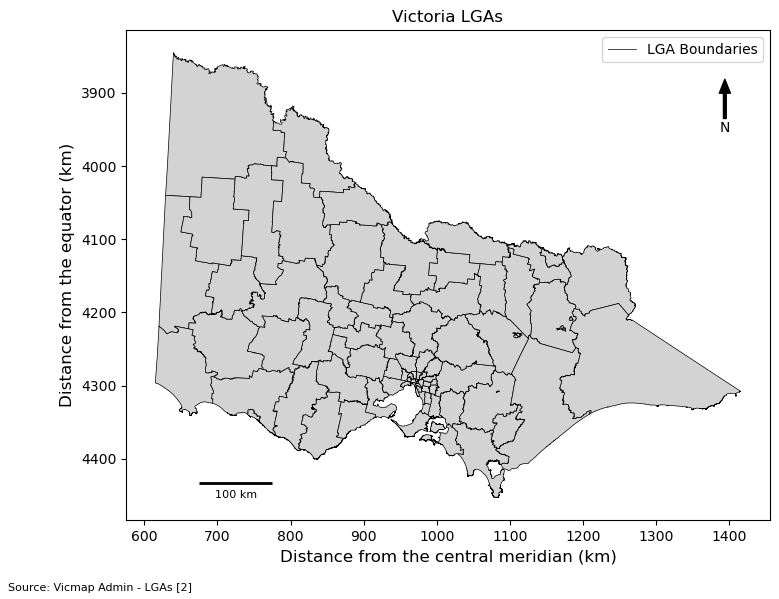

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

# Border
vicGDF.plot(ax=ax, edgecolor='black', facecolor='lightgrey', linewidth=0.5)

# Orientation
ax.annotate('N', xy=(0.93, 0.90), xytext=(0.93, 0.8),
            arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
            ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax.plot([], [], '', label="LGA Boundaries", color='black', linewidth=0.5)
ax.legend(loc='upper right', fontsize=10)

# Title and Labels
ax.set_title("Victoria LGAs", fontsize=12)
ax.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX = ax.get_xlim()[0] + 100_000
sclY = ax.get_ylim()[0] + 50_000
ax.hlines(y=sclY, xmin=sclX, xmax=sclX + 100_000, colors='black', linewidth=2)
ax.text(s='100 km', x=sclX + 50_000, y=sclY - 20_000, ha='center', fontsize=8)

# Source
ax.annotate("Source: Vicmap Admin - LGAs [2]", 
            xy=(0.01, 0.01), xycoords='figure fraction', fontsize=8, ha='left', va='bottom')

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

plt.tight_layout()
plt.show()


> **Map Interpretation**
>
> The map  presents the Local Government Areas (LGAs) of Victoria using the Vicmap topographically aligned dataset. Each LGA is represented by a grey polygon with black borders. The coordinate is labeled in kilometres from the central meridian and the equator (as per the VicGrid projection).
> 
> This map serves as a foundation for defining our study area. These LGAs will later be highlighted and overlaid with datasets on school locations, flood extents, and socio-economic indicators to investigate patterns of environmental vulnerability.


#### <a id='toc2_1_1_1_'></a>[Study Area - North Central Victoria](#toc0_)


The selected study area comprises five Local Government Areas (LGAs) in North Central Victoria, namely **Mitchell, Campaspe, Greater Bendigo, Greater Shepparton**, and **Strathbogie**. These LGAs were chosen for three key reasons: 
1. They were among the regions significantly impacted by the 2022 Victorian flood, making them relevant for a flood vulnerability analysis.
2. These LGAs are in diverse socio-economic conditions according to SEIFA scores. A spatial comparisons between more and less disadvantaged areas in relation to environmental exposure can be made. 
3. These LGAs exhibit differences in population density, school distribution, and elevation variability. 

The heterogeneity allows us to explore spatial relationships between natural hazard risk, school distribution, and socio-economic disadvantage to address broader regional planning challenges across Victoria.

In [5]:
targetLGA = ['MITCHELL', 'CAMPASPE', 'GREATER BENDIGO', 'GREATER SHEPPARTON', 'STRATHBOGIE']
lgaGDF = vicGDF[vicGDF["NAME"].isin(targetLGA)]
lgaGDF = lgaGDF.rename(columns={'OFFICIALNM': 'LGA Name'})

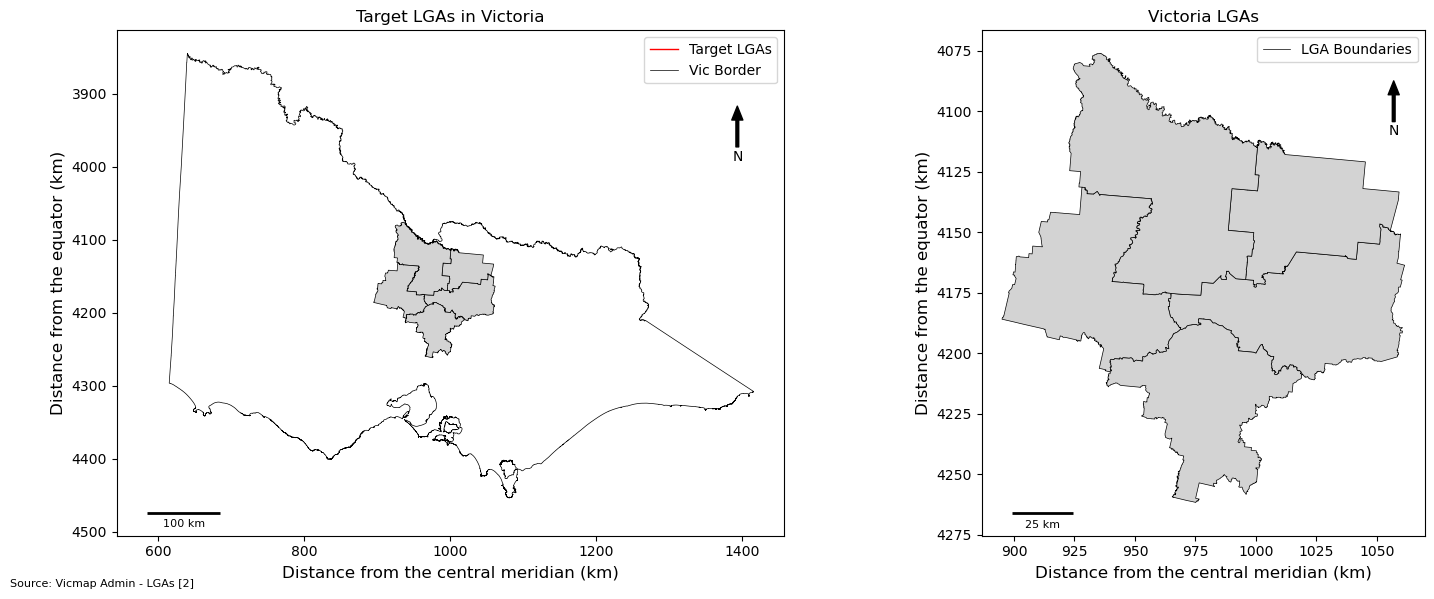

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

vicGDF.dissolve().boundary.plot(ax=ax1, edgecolor='black', linewidth=0.5)
lgaGDF.plot(ax=ax1, facecolor='lightgrey', edgecolor='black', linewidth=0.5)

# Orientation
ax1.annotate('N', xy=(0.93, 0.85), xytext=(0.93, 0.75),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax1.plot([], [], color='red', label="Target LGAs", linewidth=1)
ax1.plot([], [], color='black', label="Vic Border", linewidth=0.5)
ax1.legend(loc='upper right', fontsize=10)

# Title and labels
ax1.set_title("Target LGAs in Victoria", fontsize=12)
ax1.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax1.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX1 = ax1.get_xlim()[0] + 10_000
sclY1 = ax1.get_ylim()[0] + 10_000
ax1.hlines(y=sclY1, xmin=sclX1, xmax=sclX1 + 100_000, colors='black', linewidth=2)
ax1.text(x=sclX1 + 50_000, y=sclY1 - 20_000, s='100 km', ha='center', fontsize=8)

# Axis formatting
ax1.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

# Border
lgaGDF.plot(ax=ax2, edgecolor='black', facecolor='lightgrey', linewidth=0.5)

# Orientation
ax2.annotate('N', xy=(0.93, 0.90), xytext=(0.93, 0.8),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax2.plot([], [], '', label="LGA Boundaries", color='black', linewidth=0.5)
ax2.legend(loc='upper right', fontsize=10)

# Title and labels
ax2.set_title("Victoria LGAs", fontsize=12)
ax2.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax2.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX = ax2.get_xlim()[0] + 12_500
sclY = ax2.get_ylim()[0] + 5_000
ax2.hlines(y=sclY, xmin=sclX, xmax=sclX + 25_000, colors='black', linewidth=2)
ax2.text(s='25 km', x=sclX + 12_500, y=sclY - 6_500, ha='center', fontsize=8)

# Source annotation
fig.text(0.01, 0.01, "Source: Vicmap Admin - LGAs [2]", fontsize=8, ha='left', va='bottom')

# Axis formatting
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

plt.tight_layout()
plt.show()



> **Map Interpretation**
>
> The shaded polygons represent the 5 LGAs we selected as study area: Mitchell, Campaspe, Greater Bendigo, Greater Shepparton, and Strathbogie.

### <a id='toc2_1_2_'></a>[Victoria - 1 in 100 Year Flood Extent](#toc0_)

The 100-year flood extent polygon dataset <sup>4</sup> was critical for identifying which schools are in flood-prone zones. We selected the “Victoria – 1 in 100 Year Flood Extent” layer, which maps areas projected to flood in a 1% Annual Exceedance Probability (100-year return period) event.

By using this dataset, we assume it reliably captures the flood-prone areas in our study region. Key assumptions include:
1. The flood model data is accurate in location and extent of flood zones, (given it’s derived from hydrological models and historical data).
2. Using the 100-year ARI flood as our definition of “flood-prone” is appropriate for assessing school safety. 

We acknowledge some uncertainty in the flood polygons’ precision as the metadata notes a positional accuracy of about 5–100 m for older parts of the data

In [7]:
if False:
    floodGDF = gpd.read_file(floodPath).to_crs(epsg=7845)

    floodGDF = gpd.clip(floodGDF, vicGDF.dissolve())

In [8]:
if False:
    floodGDF.to_file('Data/Polygon/VIC Flood/lgaFlood.gpkg', layer='flood', driver='GPKG')

In [9]:
floodGDF = gpd.read_file('Data/Polygon/VIC Flood/lgaFlood.gpkg', layer='flood')
floodLGA = gpd.clip(floodGDF, lgaGDF)

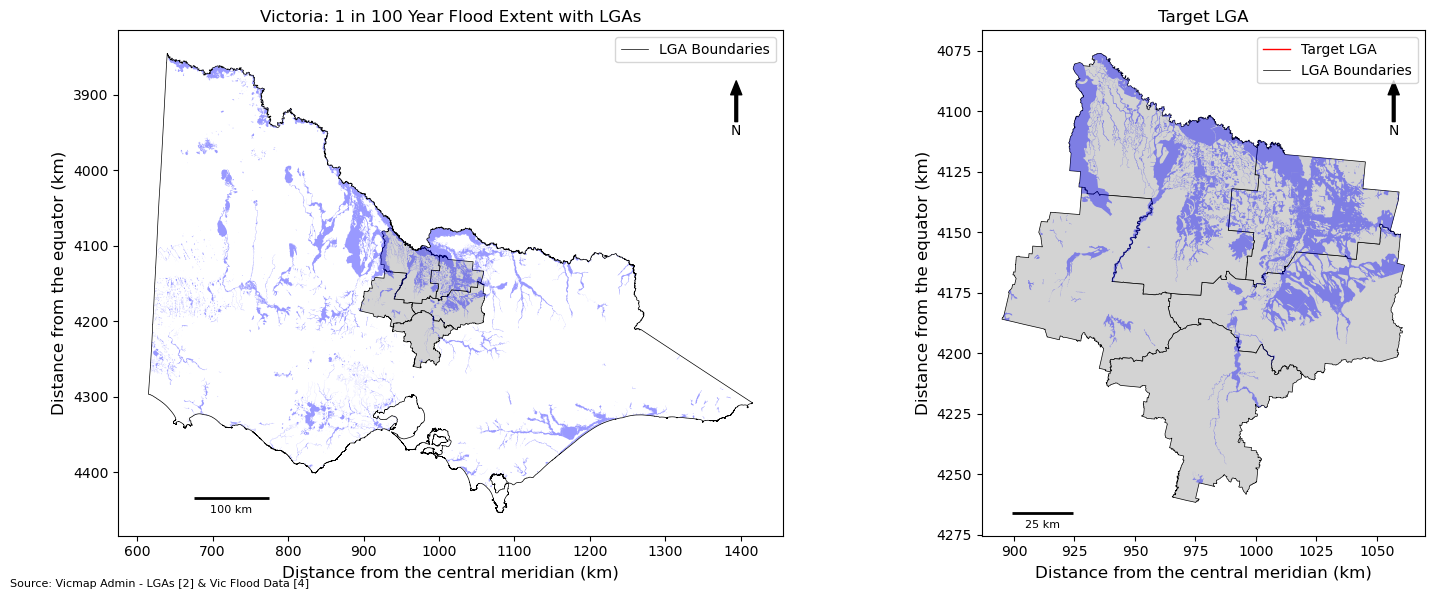

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

vicGDF.dissolve().boundary.plot(ax=ax1, edgecolor='black', linewidth=0.5)
lgaGDF.plot(ax=ax1, facecolor='lightgrey', edgecolor='black', linewidth=0.5)
floodGDF.plot(ax=ax1, color='blue', alpha=0.4, label='1 in 100 Year Flood Extent')

# Orientation
ax1.annotate('N', xy=(0.93, 0.90), xytext=(0.93, 0.8),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax1.plot([], [], '', label="LGA Boundaries", color='black', linewidth=0.5)
ax1.legend(loc='upper right', fontsize=10)

# Title and labels
ax1.set_title("Victoria: 1 in 100 Year Flood Extent with LGAs", fontsize=12)
ax1.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax1.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale bar
sclX1 = ax1.get_xlim()[0] + 100_000
sclY1 = ax1.get_ylim()[0] + 50_000
ax1.hlines(y=sclY1, xmin=sclX1, xmax=sclX1 + 100_000, colors='black', linewidth=2)
ax1.text(s='100 km', x=sclX1 + 50_000, y=sclY1 - 20_000, ha='center', fontsize=8)

# Axis formatting
ax1.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))


lgaGDF.plot(ax=ax2, facecolor='lightgrey', edgecolor='black', linewidth=0.5)
floodLGA.plot(ax=ax2, color='blue', alpha=0.4, label='1 in 100 Year Flood Extent')

# Orientation
ax2.annotate('N', xy=(0.93, 0.90), xytext=(0.93, 0.8),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax2.plot([], [], color='red', label="Target LGA", linewidth=1)
ax2.plot([], [], color='black', label="LGA Boundaries", linewidth=0.5)
ax2.legend(loc='upper right', fontsize=10)

# Title and labels
ax2.set_title("Target LGA", fontsize=12)
ax2.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax2.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX2 = ax2.get_xlim()[0] + 12_500
sclY2 = ax2.get_ylim()[0] + 5_000
ax2.hlines(y=sclY2, xmin=sclX2, xmax=sclX2 + 25_000, colors='black', linewidth=2)
ax2.text(s='25 km', x=sclX2 + 12_500, y=sclY2 - 6_500, ha='center', fontsize=8)

# Axis formatting
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

# Source annotation
fig.text(0.01, 0.01, "Source: Vicmap Admin - LGAs [2] & Vic Flood Data [4]", fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()



> **Map Interpretation**
>
> The figure above presents a two-panel map showing the spatial distribution of 1-in-100-year flood extents across Victoria, with a specific focus on our target LGAs in North Central Victoria.
>
> On the left panel, the blue shaded areas represent regions vulnerable to 1-in-100-year flooding. Our selected LGAs are highlighted in grey. From this statewide view, it is evident that significant portions of North Central Victoria lie within flood-prone zones, particularly in the northern and northeastern parts of the state where terrain is flatter and river networks are more extensive (NCCMA, 2018).
>
> The right panel zooms in on the five target LGAs. This detailed view reveals that each LGA has flood-prone corridors, typically aligned with major river systems such as the Goulburn and Campaspe Rivers (NCCMA, 2018). This implies the physical spread of flood risk could harm community safety, especially where flood zones intersect with populated areas like schools. By intersecting school location data with the mapped flood extent, we can identify which schools are potentially exposed to flood risk.


### <a id='toc2_1_3_'></a>[Statistical Area Level 2](#toc0_)

In this step, we identify the SA2 regions that fall within each LGA in the study area as SEIFA scores and census data are reported at the SA2 level, whereas our primary units of analysis (e.g., flood exposure, school counts) are aggregated at the LGA level. 

First, we reproject the dataset to EPSG:7845. After filtering for only Victorian SA2s, each SA2 polygon is clipped to the corresponding LGA boundary. The result is a new GeoDataFrame, `sa2LGA`, which assigns each SA2 polygon a corresponding `LGA Name` based on its spatial location.



In [11]:
sa2Path = 'Data/Polygon/SA2/SA2_2021_AUST_GDA2020.shp'
sa2GDF = gpd.read_file(sa2Path).to_crs(epsg=7845)

sa2GDF = sa2GDF[['SA2_CODE21', 'SA2_NAME21', 'AREASQKM21', 'STE_NAME21', 'geometry']].iloc[:-3, :].copy()
sa2GDF = sa2GDF.rename(columns={
    'SA2_CODE21': 'SA2 Code',
    'SA2_NAME21': 'SA2 Name',
    'AREASQKM21': 'Area',
    'STE_NAME21': 'State'
})
sa2GDF = sa2GDF[sa2GDF["State"] == "Victoria"].iloc[:-2, :]

sa2GDF['SA2 Code'] = sa2GDF['SA2 Code'].astype(int)

sa2GDF.head()

SA2 Code       SA2 Name      Area     State  \
644  201011001      Alfredton   52.7109  Victoria   
645  201011002       Ballarat   12.3787  Victoria   
646  201011005      Buninyong   51.5855  Victoria   
647  201011006      Delacombe   34.1607  Victoria   
648  201011007  Smythes Creek  104.7274  Victoria   

                                              geometry  
644  POLYGON ((867612.505 -4258484.096, 865228.817 ...  
645  POLYGON ((870905.748 -4257528.895, 870692.487 ...  
646  POLYGON ((872394.158 -4264374.277, 872398.991 ...  
647  POLYGON ((864539.767 -4260989.361, 864534.921 ...  
648  POLYGON ((862709.809 -4264443.168, 862696.336 ...

In [12]:
sa2 = {
    lgaName: gpd.clip(sa2GDF, lgaPoly)
    for lgaName, lgaPoly
    in lgaGDF.set_index('LGA Name').geometry.items()
}

sa2LGA = gpd.GeoDataFrame(
    pd.concat(
        [gdf.assign(**{'LGA Name': lga}) for lga, gdf in sa2.items()],
        ignore_index=True
    ),
    crs=sa2GDF.crs
)

sa2LGA.head()

SA2 Code          SA2 Name       Area     State  \
0  204011054         Alexandra  2118.9554  Victoria   
1  204011057  Mansfield (Vic.)  3927.8774  Victoria   
2  204011062               Yea  1474.2972  Victoria   
3  204011055             Euroa  2057.9046  Victoria   
4  204011058          Nagambie  1294.3498  Victoria   

                                            geometry           LGA Name  
0  MULTIPOLYGON (((1026991.773 -4207812.382, 1026...  STRATHBOGIE SHIRE  
1  MULTIPOLYGON (((1036457.832 -4202621.652, 1036...  STRATHBOGIE SHIRE  
2  MULTIPOLYGON (((1018345.888 -4208373.157, 1018...  STRATHBOGIE SHIRE  
3  POLYGON ((1013016.888 -4164093.610, 1013058.59...  STRATHBOGIE SHIRE  
4  POLYGON ((977288.001 -4175151.548, 977323.762 ...  STRATHBOGIE SHIRE

## <a id='toc2_2_'></a>[Point Data](#toc0_)

### <a id='toc2_2_1_'></a>[School Locations 2021](#toc0_)

The school locations (2021) dataset<sup>1</sup> provides the geographic coordinates and attributes of all schools in Victoria. We chose this dataset because it contains the location of every primary and secondary school. 

Since the study specifically investigates government schools, we filtered by `Education_Sector` to select only `Government`. The reason for choosing government schools is that these schools are generally open to all in the local community, unlike selective or private school. We treat government schools as our population of interest, including both primary and secondary schools, so we filtered by`School_Type` to select both `Primary` and `Secondary`. We then filtered by state, selecting schools in Victoria.

School location is originally a point. To be safe, we buffered each school location by 250m. In doing so, the possibility that flood mapping might not capture very local inundation extents were considered. A new variable `inFlood` was defined to determine whether a school is in the flood zone. If the buffer zone intersects the flood extent polygon, `inFlood` is TRUE. The first research question “Are Government schools disproportionately located in flood-prone zones?” can be addressed by counting how many of the government schools in the study area are flagged as `inFlood`.

Key assumption includes:
1. Government schools in the data are correctly identified and that excluding others does not omit any that might be needed.
2. The LGA-defined region covers all the schools we consider “North Central Victoria”.
3. A school within 250 m of the flood zone should be considered at risk

In [1]:
slDF = pd.read_csv(slPath, encoding='windows-1252')

# Choosig only Government Primary and Secondary Schools
slDF = slDF[
    (slDF['Education_Sector'] == 'Government') & 
    ((slDF['School_Type'] == 'Primary') | (slDF['School_Type'] == 'Secondary')) &
    (slDF['Address_State'] == 'VIC')
][["School_Name", "School_Type", "Education_Sector", "LGA_Name", "X", "Y"]]

slDF.columns = ['School Name', 'School Type', 'Sector', 'LGA Name', 'Longitude', 'Latitude']

slDF.head()

NameError: name 'pd' is not defined

In [14]:
slGDF = gpd.GeoDataFrame(
    slDF,
    geometry=gpd.points_from_xy(slDF.Longitude, slDF.Latitude),
    crs="EPSG:4326"                                          
).to_crs(epsg=7845)

In [15]:
slLGA = gpd.clip(slGDF, lgaGDF)
slLGA['inFlood'] = slLGA.buffer(250).intersects(floodLGA.unary_union)

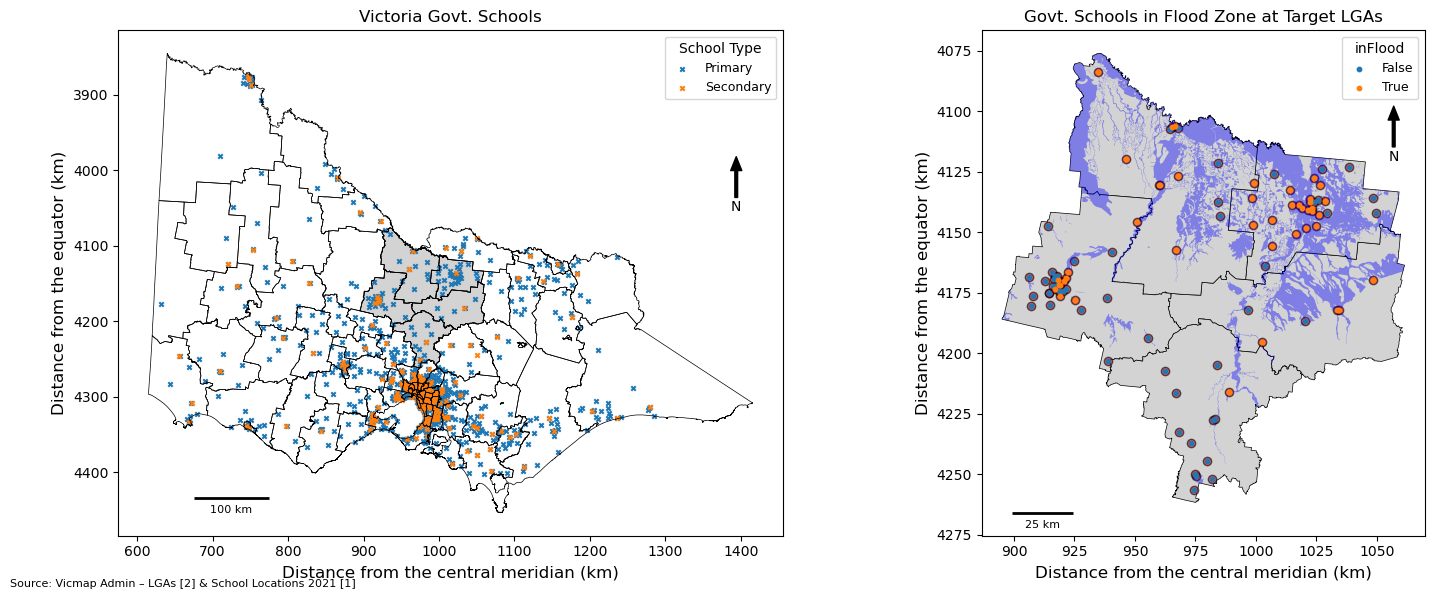

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1
vicGDF.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.5)
lgaGDF.plot(ax=ax1, facecolor='lightgrey', edgecolor='black', linewidth=0.5)

for type, group in slGDF.groupby('School Type'):
    group.plot(ax=ax1, marker='x', markersize=10, label=type, linestyle='None')

# Orientation
ax1.annotate('N', xy=(0.93, 0.75), xytext=(0.93, 0.65),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax1.legend(title="School Type", loc='upper right', fontsize=9, title_fontsize=10)

# Title and Labels
ax1.set_title("Victoria Govt. Schools", fontsize=12)
ax1.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax1.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX1 = ax1.get_xlim()[0] + 100_000
sclY1 = ax1.get_ylim()[0] + 50_000
ax1.hlines(y=sclY1, xmin=sclX1, xmax=sclX1 + 100_000, colors='black', linewidth=2)
ax1.text(s='100 km', x=sclX1 + 50_000, y=sclY1 - 20_000, ha='center', fontsize=8)

# Axis Formatting
ax1.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

# Subplot 2
lgaGDF.plot(ax=ax2, facecolor='lightgrey', edgecolor='black', linewidth=0.5)
slLGA.plot(ax=ax2, facecolor='red', edgecolor='black', linewidth=1, alpha=0.6)
floodLGA.plot(ax=ax2, color='blue', alpha=0.4, label='1 in 100 Year Flood Extent')

for type, group in slLGA.groupby('inFlood'):
    group.plot(ax=ax2, markersize=10, label=type, linestyle='None')

# Orientation
ax2.annotate('N', xy=(0.93, 0.85), xytext=(0.93, 0.75),
             arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
             ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax2.legend(title="inFlood", loc='upper right', fontsize=9, title_fontsize=10)

# Title and Labels
ax2.set_title("Govt. Schools in Flood Zone at Target LGAs", fontsize=12)
ax2.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax2.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX2 = ax2.get_xlim()[0] + 12_500
sclY2 = ax2.get_ylim()[0] + 5_000
ax2.hlines(y=sclY2, xmin=sclX2, xmax=sclX2 + 25_000, colors='black', linewidth=2)
ax2.text(s='25 km', x=sclX2 + 12_500, y=sclY2 - 6_500, ha='center', fontsize=8)

# Axis Formatting
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

# Source Annotation
fig.text(0.01, 0.01, "Source: Vicmap Admin – LGAs [2] & School Locations 2021 [1]", 
         fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()


> **Map Interpretation**
>
> This map quantifies potential flood exposure by identifying schools flagged as `inFlood = TRUE`.
>
> The left panel shows the location of all government schools in Victoria, classified by type as primary schools (blue) and secondary schools (orange). These schools are plotted over the LGA boundaries, with the five target LGAs shaded in grey.
>
> In the right panel, the government schools in the 5 LGAs are overlaid with coloured points indicating their flood exposure status. Schools falling within flood zones are highlighted in orange, while those outside are in blue. This clearly shows many schools across the study area intersect with flood zones, particularly in the center of Greater Shepparton and Greater Bendigo.
>

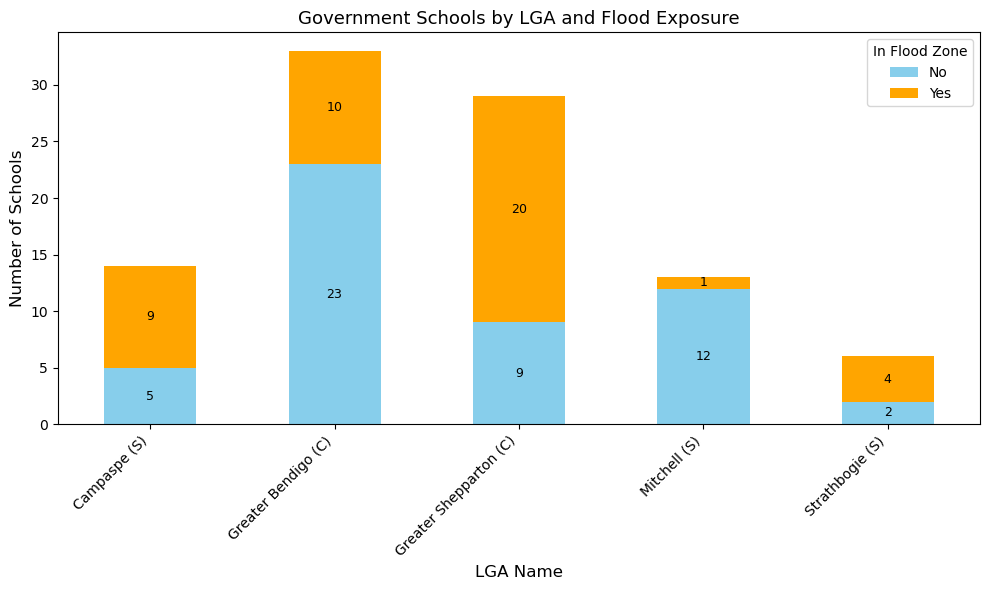

In [17]:
ax = (slLGA.groupby(['LGA Name', 'inFlood'])
           .size()
           .unstack(fill_value=0)
           .plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange']))

plt.title("Government Schools by LGA and Flood Exposure", fontsize=13)
plt.xlabel("LGA Name", fontsize=12)
plt.ylabel("Number of Schools", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="In Flood Zone", labels=["No", "Yes"])
plt.tight_layout()

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f"{int(height)}",
                    ha='center', va='center', fontsize=9, color='black')

plt.show()


> **Map Interpretation**
>
> The bar chart reveals a breakdown of government school counts in the five target LGAs of North Central Victoria, segmented by whether they fall inside (orange) or outside (blue) the flood zones. 
>
> Greater Shepparton shows the highest number of flood-exposed schools, accounting for over two-thirds of its total 29 schools. Campaspe and Strathbogie also present a high proportion with 64-67% of schools situated in flood zones. While Greater Bendigo has the highest number of schools, only 10 schools are exposed. IN contrast, Mitchell has only 1 school exposed out of 13, suggesting relatively low vulnerability in terms of flood event. This indirectly supports the first hypothesis: “Government schools are disproportionately located in flood-prone zones compared to safer areas.”
>

### <a id='toc2_2_2_'></a>[Socio-Economic Indexes for SA2, AUS 2021](#toc0_)

The SEIFA dataset<sup>5</sup> was selected to represent the socio-economic disadvantage of communities across the study area. In particular, we used the Index of Relative Socio-Economic Disadvantage (IRSD) at the SA2 level. This index summarizes socio-economic conditions (income, education, employment, etc.) in an area, which is crucial for identifying disadvantaged areas. We chose SEIFA because one of our core questions is whether flood-exposed schools are located in low socio-economic status areas, and SEIFA provides a standardized measure for that. Lower IRSD scores indicate greater disadvantage, for example, an area with a very low SEIFA score likely has more lowincome households and higher unemployment.

In practice, each school was spatially joined to the SEIFA score of the SA2 it falls in. SEIFA scores were joined to the SA2 polygon geometries. Then, the SA2 polygons were clipped to the geometry of each LGA in our study area. Any SA2s outside the study region were excluded. We ensured that the SA2 codes/names in the SEIFA data matched those in our
spatial SA2 boundary file so that the join was accurate.

Key assumptions include:
1. The SEIFA IRSD score accurately reflects disadvantage for each SA2 and is comparable across the region. 
2. Socio-economic conditions are relatively uniform within an SA2, so a school inherits the SEIFA characteristics of its surrounding SA2. 

In [18]:
seifaDF = pd.read_excel(seifaPath, sheet_name="Table 1", skiprows=5)

seifaDF = seifaDF.iloc[:-2, :3]
seifaDF.columns = ['SA2 Code', 'SA2 Name', 'Score']

seifaDF['SA2 Code'] = seifaDF['SA2 Code'].astype(int)

seifaDF.head()

SA2 Code                         SA2 Name Score
0  101021007                        Braidwood  1024
1  101021008                          Karabar   994
2  101021009                       Queanbeyan  1010
3  101021010                Queanbeyan - East  1025
4  101021012  Queanbeyan West - Jerrabomberra  1098

In [19]:
merged = sa2GDF.merge(seifaDF, on=['SA2 Code', 'SA2 Name'], how='left')
seifaSA2 = gpd.GeoDataFrame(merged, geometry='geometry', crs=sa2GDF.crs)

sa2Lga = {
    lga: gpd.clip(seifaSA2, lgaGeom)
    for lga, lgaGeom in lgaGDF.set_index("LGA Name").geometry.items()
}

seifaLGA = gpd.GeoDataFrame(
    pd.concat([gdf.assign(**{'LGA Name': lga}) for lga, gdf in sa2Lga.items()],
              ignore_index=True),
    crs=seifaSA2.crs
)

seifaLGA['Score'] = pd.to_numeric(seifaLGA['Score'], errors='coerce')

### <a id='toc2_2_3_'></a>[2021 Census GCP for SA2, VIC 2021](#toc0_)

To understand the number of students being affected in each area, Census data on student populations was used. The 2021 Census General Community Profile table G15<sup>6</sup> provides counts of people in each SA2 by type of educational institution attending, such as number of primary and secondary school students, by sex and full-time/part-time status. By quantifying the student population, the scale of impact can be evaluated. For example, an area might have a flood-exposed school, but if that area has, say, 1,000 students, the potential exposure affects more people than an area with 100 students.

We extracted the total number of primary school students and secondary school students in each SA2. Again, the student data was merged with SA2 geometry and the SA2 polygons were clipped to each LGA. 

Key assumption includes:
1. Census 2021 data accurately reflects the distribution of students across the region and that using SA2-level counts is appropriate for regional analysis.


In [20]:
cenDF = pd.read_csv(cenPath)
cenDF = cenDF[["SA2_CODE_2021", "Primary_Government_P", "Secondary_Government_P"]]
cenDF.columns = ["SA2 Code", "Primary Government Students", "Secondary Government Students"]

cenDF['SA2 Code'] = cenDF['SA2 Code'].astype(int)

cenDF.head()

SA2 Code  Primary Government Students  Secondary Government Students
0  201011001                          973                            799
1  201011002                          333                            180
2  201011005                          457                            175
3  201011006                          593                            426
4  201011007                          287                            179

In [21]:
merged = sa2GDF.merge(cenDF, on='SA2 Code', how='left')
cenSA2 = gpd.GeoDataFrame(merged, geometry='geometry', crs=sa2GDF.crs)

cenLga = {
    lga: gpd.clip(cenSA2, lgaGeom)
    for lga, lgaGeom in lgaGDF.set_index("LGA Name").geometry.items()
}

cenLGA = gpd.GeoDataFrame(
    pd.concat([gdf.assign(**{'LGA Name': lga}) for lga, gdf in cenLga.items()],
              ignore_index=True),
    crs=cenSA2.crs
)

cenLGA.head()

SA2 Code          SA2 Name       Area     State  \
0  204011054         Alexandra  2118.9554  Victoria   
1  204011057  Mansfield (Vic.)  3927.8774  Victoria   
2  204011062               Yea  1474.2972  Victoria   
3  204011055             Euroa  2057.9046  Victoria   
4  204011058          Nagambie  1294.3498  Victoria   

                                            geometry  \
0  MULTIPOLYGON (((1026991.773 -4207812.382, 1026...   
1  MULTIPOLYGON (((1036457.832 -4202621.652, 1036...   
2  MULTIPOLYGON (((1018345.888 -4208373.157, 1018...   
3  POLYGON ((1013016.888 -4164093.610, 1013058.59...   
4  POLYGON ((977288.001 -4175151.548, 977323.762 ...   

   Primary Government Students  Secondary Government Students  \
0                          242                            289   
1                          501                            403   
2                          164                            147   
3                          213                            220   
4                          238                            130   

            LGA Name  
0  STRATHBOGIE SHIRE  
1  STRATHBOGIE SHIRE  
2  STRATHBOGIE SHIRE  
3  STRATHBOGIE SHIRE  
4  STRATHBOGIE SHIRE

## <a id='toc2_3_'></a>[Raster Data](#toc0_)

### <a id='toc2_3_1_'></a>[VIC Elevation DEM 10m](#toc0_)

Digital Elevation Model (DEM) (10 m resolution)<sup>3</sup> was used to incorporate terrain information into the analysis. Undoubtedly, topography is inherently linked to flood risk. Low elevation area is more likely to be impacted by flood. By examining elevation, the questions of why certain schools are at a risk and whether there's a pattern (e.g. are flood-prone schools consistently at lower elevations?) can be answered. 

The Vicmap 10 m DEM provides the ground height above sea level for any location in Victoria. First, we reprojected the DEM raster data to EPSG:7845. Then, we clipped the reprojected DEM to the target LGAs. A downsampled raster at 100m was also saved as we may not need such a high resolution for the purpose of this analysis.



Key assumptions include:
1. DEM is reliable and sufficiently detailed to capture meaningful elevation differences at the scale of school sites.
2. In 10-meter resolution, any local elevation features (hills, valleys) that might affect flooding are reflected.



#### <a id='toc2_3_1_1_'></a>[Pre-Processing](#toc0_)

In [22]:
if False:
    dem = rasterio.open(demPath, 'r')

In [23]:
if False:
    print(f'Original CRS: {dem.crs}')

    dstCRS = 'EPSG:7845'
    dstTransform, dstWidth, dstHeight = calculate_default_transform(
        dem.crs, dstCRS,
        dem.width, dem.height,
        *dem.bounds
    )

    dstArr = np.empty((dstHeight, dstWidth), dtype=dem.dtypes[0])

    reproject(
        source      = dem.read(1),
        destination = dstArr,
        src_transform = dem.transform,
        src_crs     = dem.crs,
        dst_transform = dstTransform,
        dst_crs     = dstCRS,
        resampling  = Resampling.bilinear,
        src_nodata  = dem.nodata,
        dst_nodata  = dem.nodata
    )

    print(f'Reprojected array shape: {dstArr.shape}')
    print(f'Transformed CRS: {dstCRS}')

In [24]:
if False:
    geometry = [mapping(lgaGDF.unary_union)]

    with rasterio.open(
        'projDEM.tif', 'w',
        driver='GTiff',
        height=dstArr.shape[0],
        width=dstArr.shape[1],
        count=1,
        dtype=dstArr.dtype,
        crs=dstCRS,
        transform=dstTransform,
        nodata=dem.nodata
    ) as dst:
        dst.write(dstArr, 1)

    with rasterio.open('projDEM.tif') as src:
        clipArr, clippedTransform = mask(src, geometry, crop=True)
        clipMeta = src.meta.copy()
        clipMeta.update({
            'height': clipArr.shape[1],
            'width': clipArr.shape[2],
            'transform': clippedTransform
        })

    with rasterio.open('clippedDEM.tif', 'w', **clipMeta) as dst:
        dst.write(clipArr)

In [25]:
if False:
    def downsample(arr, transform, factor):
        outH = arr.shape[1] // factor
        outW = arr.shape[2] // factor

        outTransform = transform * Affine.scale(factor)

        outArr = np.empty((1, outH, outW), dtype=arr.dtype)

        reproject(
            source         = arr,
            destination    = outArr,
            src_transform  = transform,
            src_crs        = dstCRS,
            dst_transform  = outTransform,
            dst_crs        = dstCRS,
            resampling     = Resampling.bilinear,
            src_nodata     = dem.nodata,
            dst_nodata     = dem.nodata
        )
        return outArr, outTransform


    downsampledArr, downsampledTransform = downsample(clipArr, clippedTransform, factor=10)
    downsampledMeta = clipMeta.copy()
    downsampledMeta.update({
        'height': downsampledArr.shape[1],
        'width': downsampledArr.shape[2],
        'transform': downsampledTransform
    })

In [26]:
if False:
    outputPath = os.path.join("Data/Raster/Elevation", "lgaDEM10m.tif")

    saveMeta = clipMeta.copy()
    saveMeta.update({
        'height': clipArr.shape[1],
        'width': clipArr.shape[2],
        'transform': clippedTransform
    })

    with rasterio.open(outputPath, 'w', **saveMeta) as dst:
        dst.write(clipArr)

In [27]:
if False:
    outputPath = os.path.join("Data/Raster/Elevation", "lgaDEM100m.tif")

    with rasterio.open(outputPath, 'w', **downsampledMeta) as dst:
        dst.write(downsampledArr)

#### <a id='toc2_3_1_2_'></a>[Load DEM Raster](#toc0_)

In [28]:
rasterPath = 'Data/Raster/Elevation/lgaDEM10m.tif'

with rasterio.open(rasterPath) as src:
    dsArr = src.read(1)
    dsTransform = src.transform
    dsCRS = src.crs
    dsBounds = src.bounds
    dsMeta = src.meta
    nodata = src.nodata

print(f"Shape: {dsArr.shape}")
print(f"CRS: {dsCRS}")
print(f"Bounds: {dsBounds}")
print(f"Transform:\n{dsTransform}")

Shape: (18527, 16608)
CRS: EPSG:7845
Bounds: BoundingBox(left=895054.7992178279, bottom=-4261650.880221053, right=1061407.4814138976, top=-4076076.690490406)
Transform:
| 10.02, 0.00, 895054.80|
| 0.00,-10.02,-4076076.69|
| 0.00, 0.00, 1.00|


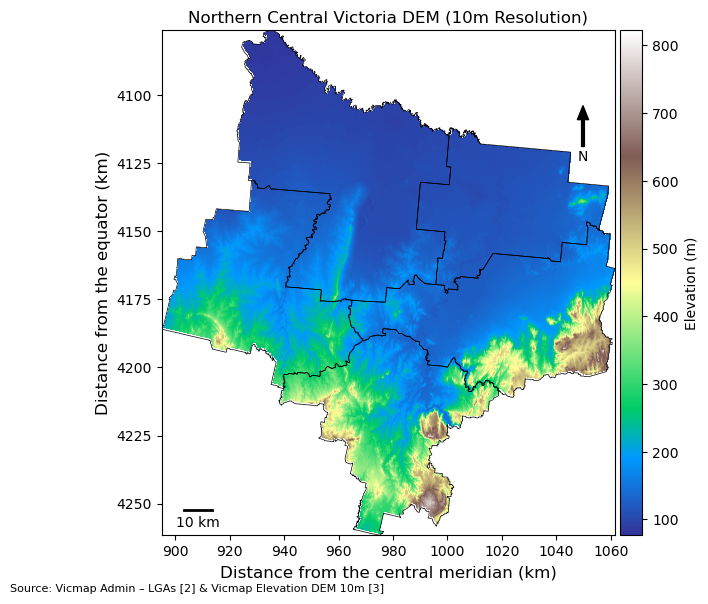

In [29]:
dsArr = np.where(dsArr == nodata, np.nan, dsArr)

fig, ax = plt.subplots(figsize=(8, 6))

# DEM background
im = rasterio.plot.show(
    dsArr,
    ax=ax,
    transform=dsTransform,
    cmap='terrain',
    interpolation='bilinear'
)
im = im.get_images()[0]

# Overlay LGA boundary
lgaGDF.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

# Orientation (North arrow)
ax.annotate(
    'N',
    xy=(0.93, 0.85), xytext=(0.93, 0.75),
    xycoords='axes fraction',
    textcoords='axes fraction',
    arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
    ha='center',
    va='center',
    fontsize=10
)

# Legend
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical').set_label('Elevation (m)')

# Scale bar
minX = dsTransform.c
maxY = dsTransform.f
maxX = minX + dsTransform.a * dsArr.shape[1]
minY = maxY + dsTransform.e * dsArr.shape[0]

sbLength = 10000  # metres
sbX = minX + (maxX - minX) * 0.05
sbY = minY + (maxY - minY) * 0.05
ax.plot([sbX, sbX + sbLength], [sbY, sbY], color='black', linewidth=2)
ax.text(
    sbX + sbLength / 2,
    sbY - (maxY - minY) * 0.01,
    '10 km',
    ha='center',
    va='top',
    fontsize=10
)

# Title and labels
ax.set_title('Northern Central Victoria DEM (10m Resolution)', fontsize=12)
ax.set_xlabel('Distance from the central meridian (km)', fontsize=12)
ax.set_ylabel('Distance from the equator (km)', fontsize=12)

# Axis formatting
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))
ax.set_aspect('equal')

# Source annotation
fig.text(0.01, 0.001, "Source: Vicmap Admin – LGAs [2] & Vicmap Elevation DEM 10m [3]", 
         fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()


> **Map Interpretation**
>
> The map above displays the Digital Elevation Model (DEM) for the five target LGAs in Northern Central Victoria. The elevation is visualized using a continuous color ramp from green (low elevation) to brown (high elevation).
>
> The map reveals that lower elevation area dominate the norhern and central regions, especially Greater Shepparton and Campaspe. Higher elevation areas are more prevalent in Strathbogie and Mitchell. This elevation gradient explains the spatial distribution of flood extents observed in earlier maps, that is, flood zones tend to coincide with flatter, low-lying areas.
>

___

# <a id='toc3_'></a>[Exploratory Spatial Data Analysis](#toc0_)

## <a id='toc3_1_'></a>[Descriptive Statistics](#toc0_)

### <a id='toc3_1_1_'></a>[SEIFA IRSD Scores Distribution](#toc0_)

In [30]:
grouped = seifaLGA.groupby('LGA Name')['Score']

summary = grouped.agg([
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Minimum', 'min'),
    ('Maximum', 'max'),
    ('Standard Deviation', 'std'),
    ('Skewness', lambda x: skew(x)),
    ('Kurtosis', lambda x: kurtosis(x))
]).round(2)

display(summary)

Mean  Median  Minimum  Maximum  \
LGA Name                                                     
CAMPASPE SHIRE            968.92   968.5      941      998   
GREATER BENDIGO CITY      991.28   994.0      912     1079   
GREATER SHEPPARTON CITY   969.23   975.0      854     1042   
MITCHELL SHIRE           1004.86  1009.5      902     1047   
STRATHBOGIE SHIRE         996.36   989.0      941     1046   

                         Standard Deviation  Skewness  Kurtosis  
LGA Name                                                         
CAMPASPE SHIRE                        18.40      0.11     -0.97  
GREATER BENDIGO CITY                  51.05      0.27     -0.90  
GREATER SHEPPARTON CITY               52.85     -0.73      0.12  
MITCHELL SHIRE                        39.21     -1.24      1.34  
STRATHBOGIE SHIRE                     32.34      0.01     -0.97

> **Table Interpretation**
>
> The table shows descriptive statistics for SEIFA IRSD scores by LGA. Among the 5 LGAs, Mitchell Shire has the highest mean and median, suggesting it is overall the least disadvantaged LGA. In contrast, Greater Shepparton City and Campaspe Shire have the lowest means (969.23 and 968.92 respectively), indicating these LGAs are relatively more disadvantaged on average. Greater Shepparton also shows negative skewness (-0.73), implying low outliers pulling the distribution towards the left. Meanwhile,  Greater Bendigo City has the widest range and the highest standard deviation (51.05), suggesting high variation in socio-economic status across its SA2 regions.
> 
>

<Figure size 1000x500 with 0 Axes>

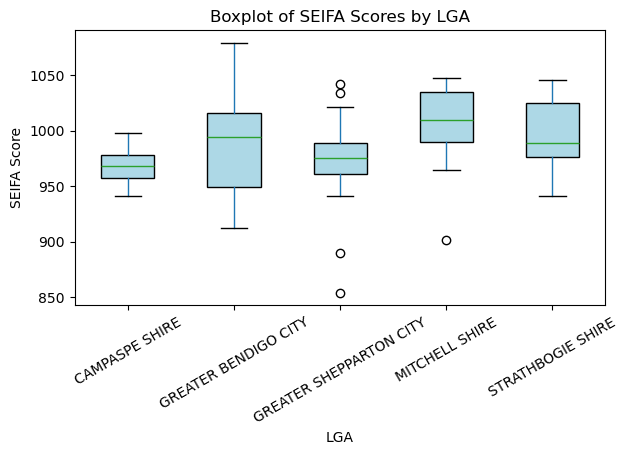

In [31]:
plt.figure(figsize=(10, 5))
seifaLGA.boxplot(column='Score', by='LGA Name', grid=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title('Boxplot of SEIFA Scores by LGA')
plt.suptitle('')
plt.xlabel('LGA')
plt.ylabel('SEIFA Score')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

> **Map Interpretation**
>
> From the boxplots, Campaspe and Greater Shepparton have lower medians and tighter boxes, supporting the findings above. Greater Bendigo shows the widest IQR and multiple outliers, confirming high variability. Likewise, Mitchell has the highest median and displays a slight right skewed distribution. 
> 
> According to the findings, it's likely there is a spatial association between flood-exposed schools and low SEIFA areas. To study the association, Raster Analysis and Geographically Weighted Regression were conducted in following parts.

### <a id='toc3_1_2_'></a>[School Type Count at Each SAs](#toc0_)

In [32]:
pivot = (slLGA.groupby(['LGA Name','School Type'])
                   .size()
                   .unstack(fill_value=0)
                   .assign(Total=lambda d: d.sum(1))
                   .sort_values('Total',ascending=False))

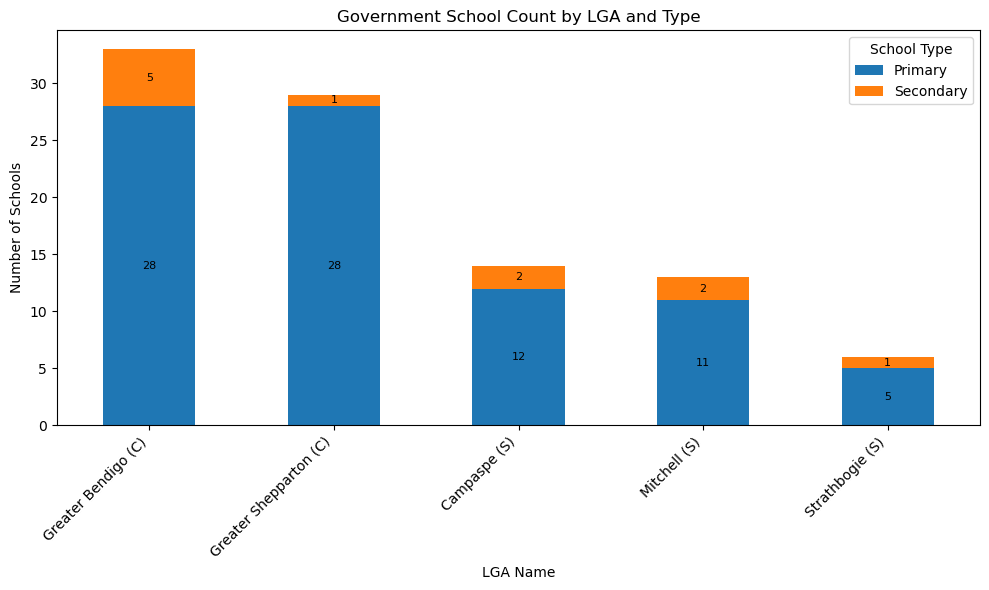

In [33]:
ax = pivot[['Primary', 'Secondary']].plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Government School Count by LGA and Type')
plt.xlabel('LGA Name')
plt.ylabel('Number of Schools')
plt.xticks(rotation=45, ha='right')
plt.legend(title='School Type')
plt.tight_layout()

for c in ax.containers:
    ax.bar_label(c, label_type='center', fontsize=8, color='black')

plt.show()


> **Map Interpretation**
>
> The chart displays the number of government primary and secondary schools in each LGA to provide information on the distribution of educational institutes. Greater Bendigo has the highest total number of government schools, with 28 primary and 5 secondary schools. Greater Shepparton follows closely with 29 schools, but has only 1 secondary school. However, Strathbogie has the lowest total number of schools. 

## <a id='toc3_2_'></a>[Point Pattern Analysis](#toc0_)

### <a id='toc3_2_1_'></a>[School Distribution in LGAs](#toc0_)

A combination of point pattern analysis methods was employed to investigae the spatial distribution of government schools in the 5 LGAs. These techniques are widely used to assess the degree of clustering, randomness, or dispersion in the distribution. We applied both distance-based and density-based approaches. A comparison of different methods is discussed at the end of the project.

#### <a id='toc3_2_1_1_'></a>[Distance-based Methods](#toc0_)

##### <a id='toc3_2_1_1_1_'></a>[Average Nearest Neighbour Analysis](#toc0_)

Average Nearest Neighbour Analysis is a distance-based point pattern analysis method used to determine whether a set of spatial points (e.g. schools) is randomly distributed, clustered, or uniformly dispersed across a geographic area. According to the equations shown below (Aryal, 2025), the observed mean distance calculates the average distance between each point and its nearest neighbor in the dataset, whereas the expected mean distance calculates expected average distance between points if they were randomly distributed, based on point density. The Nearest Neighbour Ratio (R) obtained can then be used to infer the spatial pattern:
- **R < 1**: The distribution is clustered.
- **R ≈ 1**: The distribution is random.
- **R > 1**: The distribution is even.

In our analysis, a hypothesis test was conducted to determine whether the pattern is statistically significant. 

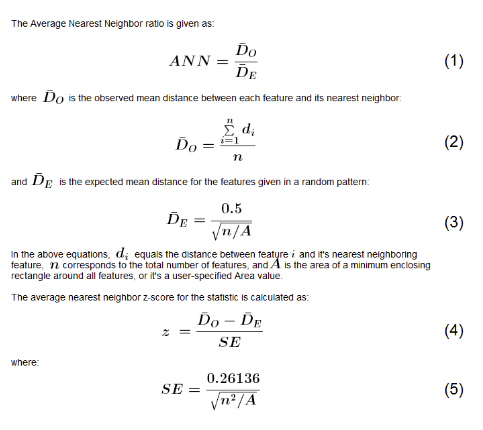

*Adapted from: https://pro.arcgis.com/en/pro-app/tool-reference/spatialstatistics/
h-how-average-nearest-neighbor-distance-spatialst.
htm*


In [34]:
rows = []

for lgaName, lgaPoly in lgaGDF.set_index("LGA Name").geometry.items():

    schoolsInLGA = slLGA[slLGA.within(lgaPoly)]

    coords = [(g.x, g.y) for g in schoolsInLGA.geometry]
    pp = PointPattern(np.array(coords))

    obs = pp.mean_nnd
    n   = pp.n
    dens = n / lgaPoly.area

    exp = 0.5 / np.sqrt(dens)
    sd  = 0.26136 / np.sqrt(dens)
    zVal = (obs - exp) / sd
    pVal = 2 * (1 - norm.cdf(abs(zVal)))

    Rval = obs / exp
    patt = 'clustered' if Rval < 1 else 'dispersed' if Rval > 1 else 'random'

    rows.append({
        'LGA Name': lgaName,
        'Schools': n,
        'Obs Mean NND (m)': round(obs, 2),
        'Exp Mean NND (m)': round(exp, 2),
        'R': round(Rval, 2),
        'Z-score': round(zVal, 2),
        'p-value': round(pVal, 3),
        'Pattern': patt
    })

annLGA = pd.DataFrame(rows)
display(annLGA)


LGA Name  Schools  Obs Mean NND (m)  Exp Mean NND (m)     R  \
0        STRATHBOGIE SHIRE        6          10487.28          11759.79  0.89   
1  GREATER SHEPPARTON CITY       29           4663.88           4574.75  1.02   
2           CAMPASPE SHIRE       14           9765.29           8991.65  1.09   
3     GREATER BENDIGO CITY       33           4900.61           4777.70  1.03   
4           MITCHELL SHIRE       13           6227.85           7444.40  0.84   

   Z-score  p-value    Pattern  
0    -0.21    0.836  clustered  
1     0.04    0.970  dispersed  
2     0.16    0.869  dispersed  
3     0.05    0.961  dispersed  
4    -0.31    0.755  clustered

> **Table Interpretation**
>
> From the table, key findings include:
> - Strathbogie Shire showed a nearest neighbour ratio (R) of 0.89, suggesting slight clustering, but the high p-value (0.836) indicates this pattern is not statistically significant.
> - Greater Shepparton City (R = 1.02) and Greater Bendigo City (R = 1.03) both exhibit near-random distributions.
> - Campaspe Shire (R = 1.09, p = 0.869) also suggests mild dispersion, but again lacks statistical significance.
> - Mitchell Shire had an R value of 0.84, shoing a weak clustering. The result was also non-significant (p = 0.755).
> 
> Overall, all five LGAs display p-values above the 0.05 threshold, indicating that no clustering or dispersion patterns observed are statistically significant. As a result government school distribution within each LGA does not exhibit strong clustering or dispersion.
>

In [35]:
rows = []

for label, group in slLGA.groupby('inFlood'):
    labelStr = 'In Flood' if label else 'Not in Flood'

    coords = [(pt.x, pt.y) for pt in group.geometry]
    pp = PointPattern(np.array(coords))

    obs = pp.mean_nnd
    n   = pp.n
    area = pp.mbb_area
    dens = n / area

    exp = 0.5 / np.sqrt(dens)
    sd  = 0.26136 / np.sqrt(dens)
    zVal = (obs - exp) / sd
    pVal = 2 * (1 - norm.cdf(abs(zVal)))

    Rval = obs / exp
    patt = 'clustered' if Rval < 1 else 'dispersed' if Rval > 1 else 'random'

    rows.append({
        'Group': labelStr,
        'Schools': n,
        'Obs Mean NND (m)': round(obs, 2),
        'Exp Mean NND (m)': round(exp, 2),
        'R': round(Rval, 2),
        'Z-score': round(zVal, 2),
        'p-value': round(pVal, 3),
        'Pattern': patt
    })

annFlood = pd.DataFrame(rows)
display(annFlood)

Group  Schools  Obs Mean NND (m)  Exp Mean NND (m)     R  Z-score  \
0  Not in Flood       51           7379.01          10270.36  0.72    -0.54   
1      In Flood       44           6427.04           9933.90  0.65    -0.68   

   p-value    Pattern  
0    0.590  clustered  
1    0.499  clustered

> **Table Interpretation**
>
> The ANN analysis was also used to compare the spatial arrangement of schools located within flood zones versus those outside flood zones. From the table, key findings include:
> - Schools in flood zones showed a nearest neighbour ratio (R) of 0.65 with a p-value of 0.499, indicating a moderate tendency toward clustering, but the result is not statistically significant
> - Schools not in flood zones exhibited an R value of 0.72  and p-value of 0.590, also suggesting a weak clustering pattern.
>
> Therefore, while schools in both groups appear to be somewhat clustered, there is no strong statistical evidence that flood-prone schools are more spatially concentrated than the non-flooded counterparts.
>


##### <a id='toc3_2_1_1_2_'></a>[Ripley's K and L Functions](#toc0_)

Likewise, Ripley's K and L functions are also used in point pattern analysis to determine spatial distribution, but across multiple spatial scales rather than just at a single nearest-neighbour distance. Ripley’s K function measures the expected number of other points within a distance d of a randomly chosen point, standardized by point density. Ripley's L Function is the transformation of the K function to linearize the output, making it easier to interpret deviations from randomness.

**Ripley's K Functions**

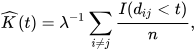 
where λ is the intensity (point density per area).



- $K(d) > \pi d^2$: clustering at distance $d$
- $K(d) < \pi d^2$: dispersion
- $K(d) = \pi d^2$: complete spatial randomness

**Ripley's K Functions**

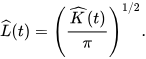

- $L(d) > 0$: clustering at distance $d$
- $L(d) < 0$: dispersion
- $L(d) = 0$: randomness







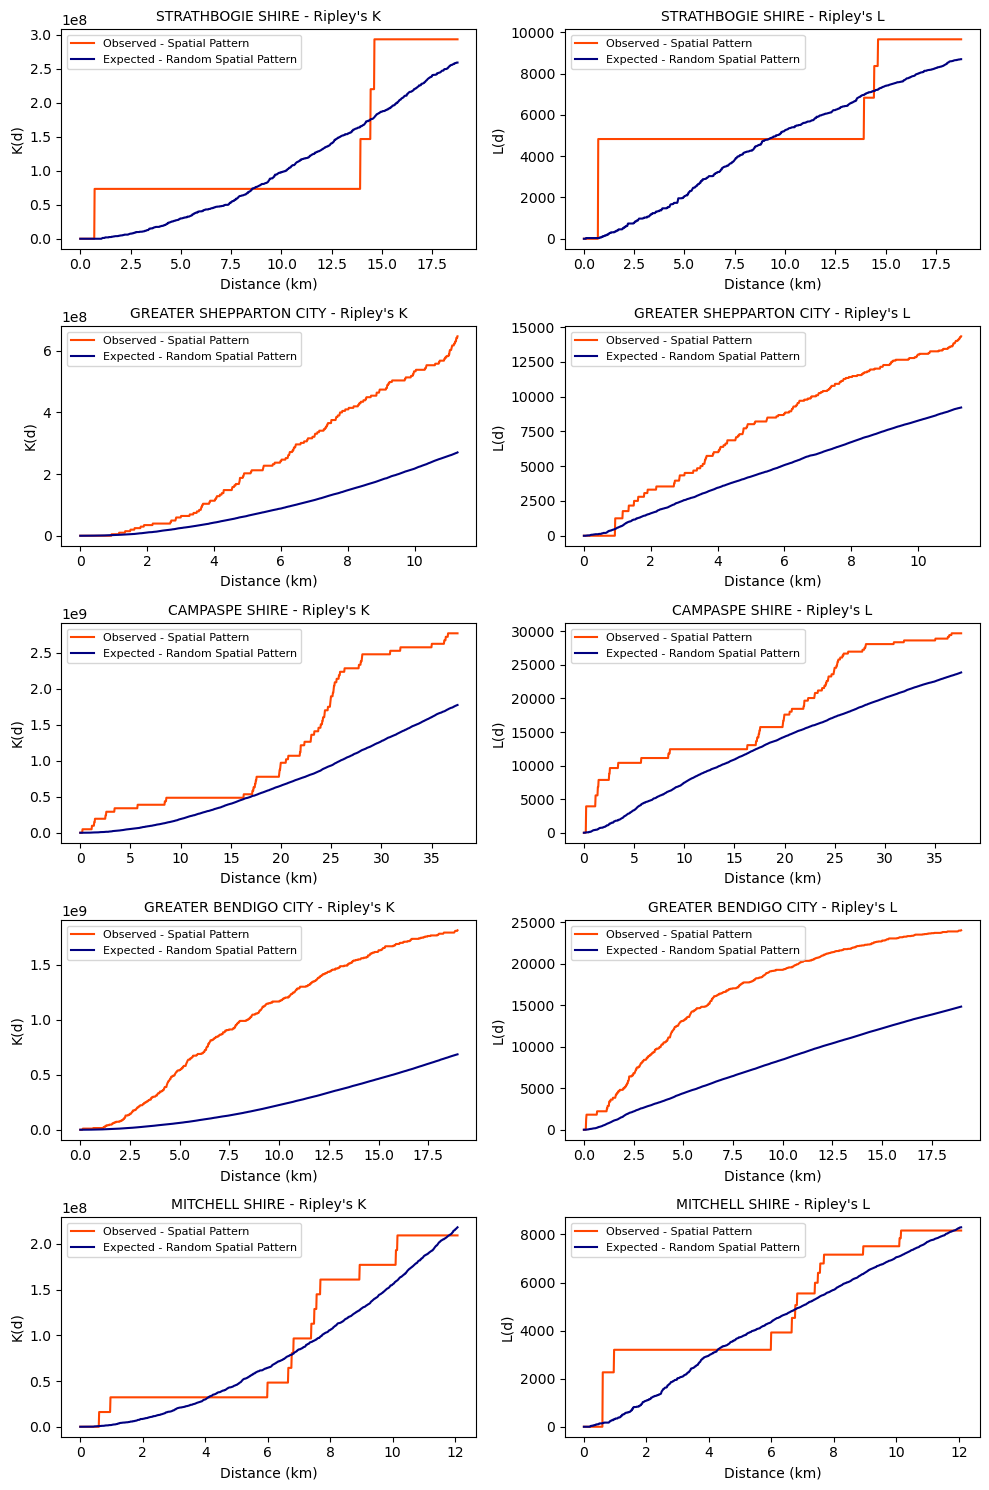

In [36]:
selectedLGAs = list(lgaGDF.set_index("LGA Name").geometry.items())

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
axes = axes.reshape(5, 2)

for i, (lgaName, lgaPoly) in enumerate(selectedLGAs):
    schoolsInLGA = slLGA[slLGA.within(lgaPoly)]
    coords = np.array([(g.x, g.y) for g in schoolsInLGA.geometry])
    kRes = k_test(coords, support=1000, keep_simulations=True, n_simulations=99)
    lRes = l_test(coords, support=1000, keep_simulations=True, n_simulations=99)

    axK = axes[i, 0]
    axK.plot(kRes.support / 1000, kRes.statistic, 'orangered', label='Observed - Spatial Pattern')
    axK.plot(kRes.support / 1000, kRes.simulations.mean(0), 'navy', label='Expected - Random Spatial Pattern')
    axK.set_title(f"{lgaName} - Ripley's K", fontsize=10)
    axK.set_xlabel("Distance (km)")
    axK.set_ylabel("K(d)")
    axK.legend(fontsize=8)

    axL = axes[i, 1]
    axL.plot(lRes.support / 1000, lRes.statistic, 'orangered', label="Observed - Spatial Pattern")
    axL.plot(lRes.support / 1000, lRes.simulations.mean(0), 'navy', label="Expected - Random Spatial Pattern")
    axL.set_title(f"{lgaName} - Ripley's L", fontsize=10)
    axL.set_xlabel("Distance (km)")
    axL.set_ylabel("L(d)")
    axL.legend(fontsize=8)

plt.tight_layout()
plt.show()


> **Graph Interpretation**
>
> The Ripley’s K and L function plots reveal how the spatial distribution of government schools varies across the five target LGAs at multiple distance scales. When observed K of L value is greater than expected, clustering of points at a given distance band is indicated. Oppositely, if the observed value is lower than expected, it suggests dispersion.
> 
> From the graph, key findings include:
> - In **Strathbogie Shire**, the observed K and L curves diverge from the expected line primarily at larger distances (over 14 km). This indicates while schools are relatively spread out at local scales, there is significant clustering at broader spatial extents.
> - In **Greater Shepparton City and Greater Bendigo City**, schools strongly clustered even at small distances (~2 km), suggesting central areas with many schools close to together.
> - In **Campaspe Shire**, schools appears to be randomly distributed at small scales but show clear clusters at distances over 15 km, reflecting multiple dispersed townships.
> - In **Mitchell Shire**, schools shows pattern close to random, with minor clustering at intermediate distances. This reflects schools are likely grouped around key population center. 
> 
>



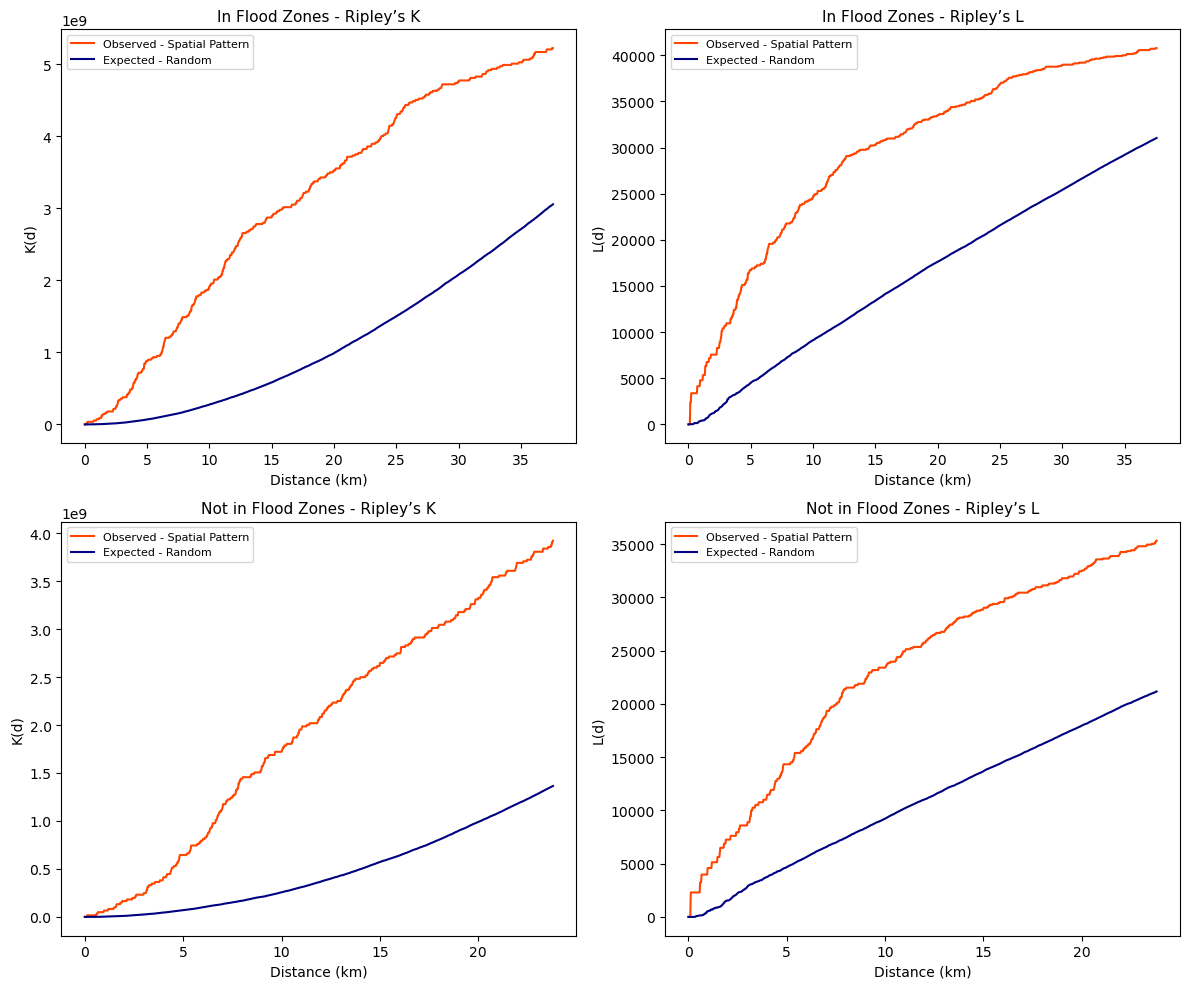

In [37]:
groups = {
    'In Flood Zones': slLGA[slLGA['inFlood'] == True],
    'Not in Flood Zones': slLGA[slLGA['inFlood'] == False]
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.reshape(2, 2)

for i, (label, gdf) in enumerate(groups.items()):
    coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])

    kRes = k_test(coords, support=1000, keep_simulations=True, n_simulations=99)
    lRes = l_test(coords, support=1000, keep_simulations=True, n_simulations=99)

    # Ripley's K
    axK = axes[i, 0]
    axK.plot(kRes.support / 1000, kRes.statistic, 'orangered', label='Observed - Spatial Pattern')
    axK.plot(kRes.support / 1000, kRes.simulations.mean(0), 'navy', label='Expected - Random')
    axK.set_title(f"{label} - Ripley’s K", fontsize=11)
    axK.set_xlabel("Distance (km)")
    axK.set_ylabel("K(d)")
    axK.legend(fontsize=8)

    # Ripley's L
    axL = axes[i, 1]
    axL.plot(lRes.support / 1000, lRes.statistic, 'orangered', label='Observed - Spatial Pattern')
    axL.plot(lRes.support / 1000, lRes.simulations.mean(0), 'navy', label='Expected - Random')
    axL.set_title(f"{label} - Ripley’s L", fontsize=11)
    axL.set_xlabel("Distance (km)")
    axL.set_ylabel("L(d)")
    axL.legend(fontsize=8)

plt.tight_layout()
plt.show()

> **Graph Interpretation**
>
> These plots reveal how the spatial distribution of government schools in flood zones and outside flood zones differs across multiple distance scales. 
> 
> From the graph, key findings include:
> - For **schools in flood zones**, show a strong upward deviation from the expected random pattern across all distances. This indicates a strong and sustained clustering tendency at both short and long distances. The pattern suggests that schools in flood-prone areas tend to be located in close proximity to one another.
> 
> - For **schools not in flood zones**, the observed curves also lie above the expected values, confirming some degree of clustering. However, the magnitude of divergence is smaller compared to the flood-zone group, suggesting weaker clustering.
> 
> To sum up, Government schools located in flood zones exhibit stronger spatial clustering than those in non-flooded areas. This pattern reinforces the idea that vulnerable clusters exist within flood-prone zones.
> 

##### <a id='toc3_2_1_1_3_'></a>[Ripley's G and F Function](#toc0_)

Ripley’s G and F functions serve as extensions to the average nearest neighbour approach, assessing local-scale clustering or dispersion. Ripley’s G Function measures the distribution of nearest-neighbour distances from each point to the closest other point in the dataset. G(d) gives the probability that the nearest neighbour of a randomly chosen point is within distance d. Ripley’s F Function measures the distribution of distances from random locations in the study area to the nearest observed point. F(d) is the probability that a random location lies within distance d of the nearest point.

**Ripley’s G Function**
- Observed G(d) > Expected G(d): Clustering
- Observed G(d) < Expected G(d): Dispersion

**Ripley’s F Function**
- Observed F(d) > Expected F(d): Clustering
- Observed F(d) < Expected F(d): Dispersion

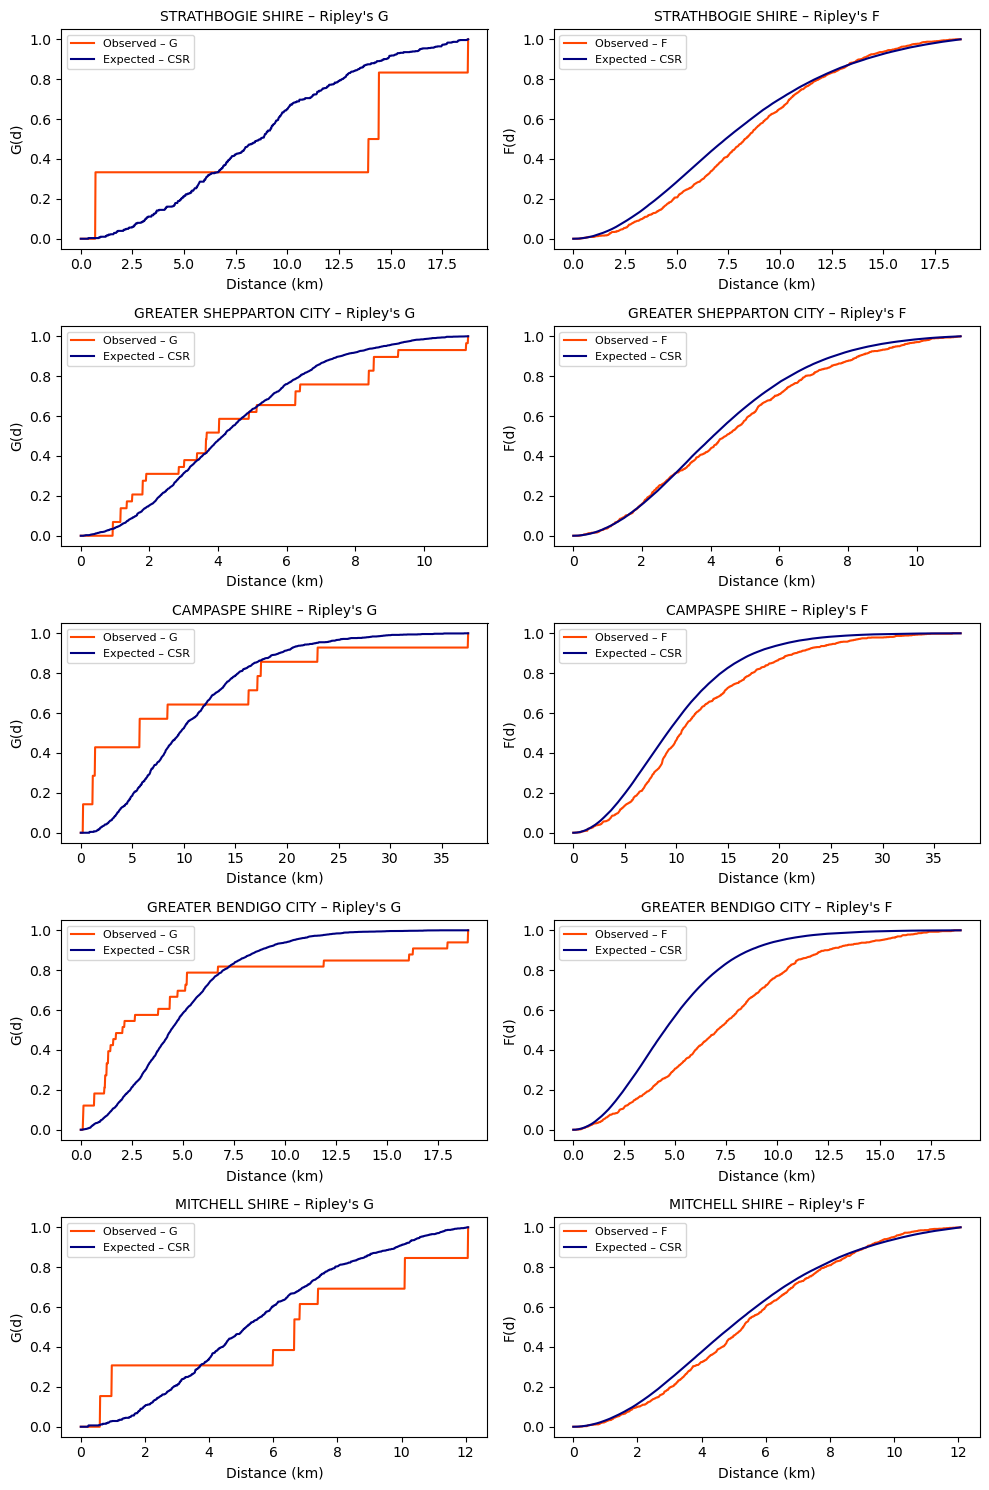

In [38]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
axes = axes.reshape(5, 2)

for i, (lgaName, lgaPoly) in enumerate(selectedLGAs):
    schoolsInLGA = slLGA[slLGA.within(lgaPoly)]
    coords = np.array([(pt.x, pt.y) for pt in schoolsInLGA.geometry])

    gRes = g_test(coords, support=1000, keep_simulations=True, n_simulations=99)
    fRes = f_test(coords, support=1000, keep_simulations=True, n_simulations=99)

    axG = axes[i, 0]
    axG.plot(gRes.support / 1000, gRes.statistic,  'orangered', label='Observed – G')
    axG.plot(gRes.support / 1000, gRes.simulations.mean(0), 'navy', label='Expected – CSR')
    axG.set_title(f"{lgaName} – Ripley's G", fontsize=10)
    axG.set_xlabel("Distance (km)")
    axG.set_ylabel("G(d)")
    axG.legend(fontsize=8)

    axF = axes[i, 1]
    axF.plot(fRes.support / 1000, fRes.statistic,  'orangered', label='Observed – F')
    axF.plot(fRes.support / 1000, fRes.simulations.mean(0), 'navy', label='Expected – CSR')
    axF.set_title(f"{lgaName} – Ripley's F", fontsize=10)
    axF.set_xlabel("Distance (km)")
    axF.set_ylabel("F(d)")
    axF.legend(fontsize=8)

plt.tight_layout()
plt.show()

> **Graph Interpretation**
>
> The Ripley’s G and F function plots provide additional insights into the local-scale spatial patterns of government school distributions across the five LGAs. When the observed G(d) or F(d) curve rises above the expected CSR (Complete Spatial Randomness) curve, it indicates clustering. If the curve falls below the expected line, it suggests dispersion.
> 
> From the graph, key findings include:
> - In **Strathbogie Shire**, schools are slightly dispersed.
> 
> - In **Greater Shepparton & Greater Bendigo**, schools are clustered strongly at very short distance (~2 km), indicating dense local distribution.
> 
> - In **Campaspe Shire**, there is evidence of local clustering, but dispersed at long distance. There are possibly clustered islands in a dispersed landscape.
> 
> - In **Mitchell Shire**:  Distribution of schools is largely random, with possible mild dispersion.
> 

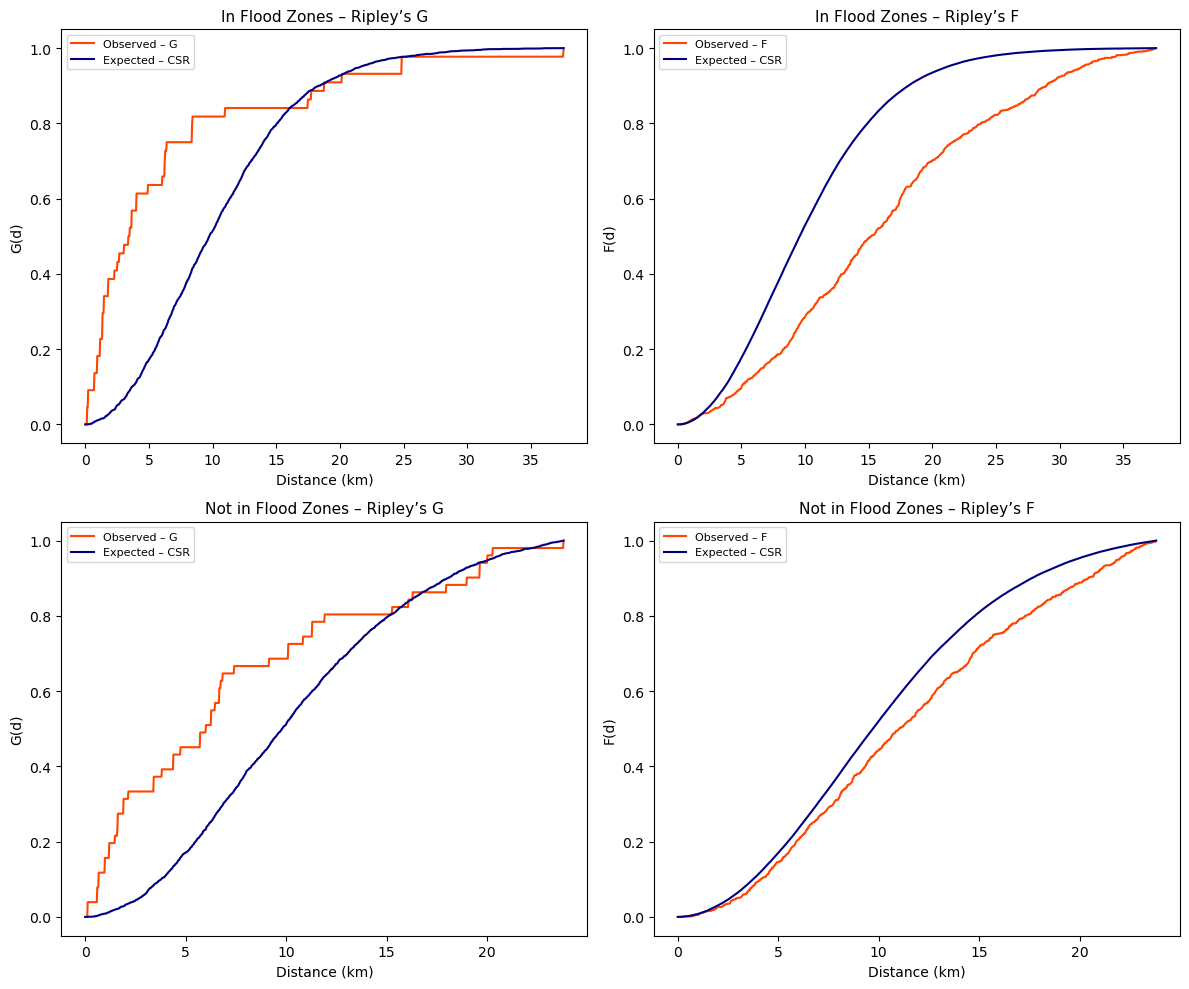

In [39]:
groups = {
    'In Flood Zones': slLGA[slLGA['inFlood'] == True],
    'Not in Flood Zones': slLGA[slLGA['inFlood'] == False]
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.reshape(2, 2)

for i, (label, gdf) in enumerate(groups.items()):
    coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
    
    if len(coords) < 5:
        continue  # Skip groups with too few points

    gRes = g_test(coords, support=1000, keep_simulations=True, n_simulations=99)
    fRes = f_test(coords, support=1000, keep_simulations=True, n_simulations=99)

    # G plot
    axG = axes[i, 0]
    axG.plot(gRes.support / 1000, gRes.statistic, 'orangered', label='Observed – G')
    axG.plot(gRes.support / 1000, gRes.simulations.mean(0), 'navy', label='Expected – CSR')
    axG.set_title(f"{label} – Ripley’s G", fontsize=11)
    axG.set_xlabel("Distance (km)")
    axG.set_ylabel("G(d)")
    axG.legend(fontsize=8)

    # F plot
    axF = axes[i, 1]
    axF.plot(fRes.support / 1000, fRes.statistic, 'orangered', label='Observed – F')
    axF.plot(fRes.support / 1000, fRes.simulations.mean(0), 'navy', label='Expected – CSR')
    axF.set_title(f"{label} – Ripley’s F", fontsize=11)
    axF.set_xlabel("Distance (km)")
    axF.set_ylabel("F(d)")
    axF.legend(fontsize=8)

plt.tight_layout()
plt.show()

> **Graph Interpretation**
>
> The Ripley’s G and F functions assess the local-scale spatial patterns of schools located inside and outside flood zones.
> 
> From the graph, key findings include:
> - For **Schools in Flood Zones**, the G function shows a sharp rise at small distances, indicating that schools are closely spaced and clustered at fine scales (within ~5 km). The F function lies well below the CSR expectation, suggesting large gaps between some school clusters. Together, these patterns reflect a layout where schools are densely grouped in pockets.
> 
> - For **Schools Not in Flood Zones**, the G curve still lies above CSR, but the rise is more gradual, indicating moderate clustering. The F curve remains close to the expected CSR, implying a more uniform distribution with fewer large gaps across the region.
> 
> Both G and F functions confirm that government schools in flood zones are more spatially clustered, while schools outside flood zones tend to be more evenly distributed. This reinforces concerns that flood-prone areas may host concentrated clusters of schools, increasing localized vulnerability during extreme events.


#### <a id='toc3_2_1_2_'></a>[Density-based methods](#toc0_)

##### <a id='toc3_2_1_2_1_'></a>[Quadrat Count](#toc0_)
Quadrat count is a density-based method used in point pattern analysis to assess the spatial distribution of points (e.g., schools, trees, crimes) across a defined area. This method divides the study area into a grid of equal-sized rectangular or square units, called quadrats. In each quadrat, the number of points is counted and the distribution is analyzed using summary statistics. 


**Variance to Mean Ratio**:

$$
\text{VMR} = \frac{\text{Variance of counts}}{\text{Mean of counts}}
$$

* **VMR > 1**: Clustering
* **VMR ≈ 1**: Random distribution
* **VMR ≈ 0**: Uniform distribution





In [40]:
rows = []

for lgaName, lgaPoly in lgaGDF.set_index('LGA Name').geometry.items():
    schoolsInLGA = slLGA[slLGA.within(lgaPoly)]
    coords = np.array([(g.x, g.y) for g in schoolsInLGA.geometry])

    pp = PointPattern(coords)
    qs = QStatistic(pp, shape='rectangle', nx = 4, ny = 4)

    counts = np.array(list(qs.mr.point_location_sta().values()))

    mean = np.mean(counts)
    var = np.var(counts, ddof = 1)
    vmr = var / mean
    chi2 = qs.chi2
    df = qs.df
    pVal = qs.chi2_pvalue
    
    pattern = 'clustered' if vmr > 1.1 else ('uniform' if vmr < 0.9 else 'random')
    rows.append({
        'LGA Name': lgaName,
        'Cells': len(counts),
        'Points': pp.n,
        'VMR': round(vmr, 2),
        'Chi-square': round(chi2, 2),
        'p-value': round(pVal, 3),
        'Pattern': pattern
    })

quadLGA = pd.DataFrame(rows).sort_values('LGA Name')
display(quadLGA)

LGA Name  Cells  Points   VMR  Chi-square  p-value  \
2           CAMPASPE SHIRE     16      14  1.20       18.00    0.263   
3     GREATER BENDIGO CITY     16      33  4.94       74.15    0.000   
1  GREATER SHEPPARTON CITY     16      29  2.66       39.97    0.000   
4           MITCHELL SHIRE     16      13  1.35       20.23    0.163   
0        STRATHBOGIE SHIRE     16       6  1.02       15.33    0.428   

     Pattern  
2  clustered  
3  clustered  
1  clustered  
4  clustered  
0     random

> **Table Interpretation**
>
> The Quadrat Count method evaluates the spatial distribution of government schools across the five LGAs by dividing each region. The Variance-to-Mean Ratio (VMR) and associated Chi-square test determine whether the observed distribution significantly deviates from randomness.
> 
> From the table, key findings include:
> - **Greater Bendigo & Greater Shepparton City** shows strong and statistically significant clustering of schools, with p < 0.001.
> 
> - **Campaspe Shire & Mitchell Shire** has a VMR of 1.20 and 1.35 respectively, suggesting mild clustering, but the result is not statistically significant.
> 
> - **Strathbogie Shire** shows random distribution and test is non-significant.
> 
> In summary, only Greater Bendigo and Greater Shepparton show statistically significant school clustering; the other LGAs do not deviate from complete spatial randomness at the 5 % confidence interval.


In [41]:
groups = {
    'In Flood': slLGA[slLGA['inFlood'] == True],
    'Not in Flood': slLGA[slLGA['inFlood'] == False]
}

rows = []

for label, gdf in groups.items():
    coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
    if len(coords) < 5:
        continue  # too few points for quadrat count

    pp = PointPattern(coords)
    qs = QStatistic(pp, shape='rectangle', nx=4, ny=4)  # 4x4 grid

    counts = np.array(list(qs.mr.point_location_sta().values()))
    mean = np.mean(counts)
    var = np.var(counts, ddof=1)
    vmr = var / mean
    chi2 = qs.chi2
    df = qs.df
    pVal = qs.chi2_pvalue

    pattern = 'clustered' if vmr > 1.1 else ('uniform' if vmr < 0.9 else 'random')

    rows.append({
        'Group': label,
        'Cells': len(counts),
        'Points': pp.n,
        'VMR': round(vmr, 2),
        'Chi-square': round(chi2, 2),
        'p-value': round(pVal, 3),
        'Pattern': pattern
    })

quadFlood = pd.DataFrame(rows)
display(quadFlood)

Group  Cells  Points   VMR  Chi-square  p-value    Pattern
0      In Flood     16      44  5.07       76.00      0.0  clustered
1  Not in Flood     16      51  7.66      114.96      0.0  clustered

> **Table Interpretation**
>
> The Quadrat Count method evaluates the sspatial clustering of schools inside and outside flood zones using a uniform 4×4 grid.
> 
> From the table, key findings include:
> - For **In Flood Zones**, The VMR of 5.07 and Chi-square value of 76.00 (p < 0.001) indicate a strong and statistically significant clustering of schools. This suggests that within flood-prone areas, schools are not evenly distributed but tend to aggregate in specific high-risk clusters, potentially corresponding to low-lying areas.
> 
> - For **Not In Flood Zones**, an even higher VMR of 7.66 and Chi-square value of 114.96 (p < 0.001) were observed. This reflects an even stronger degree of significant clustering among schools located in safer areas. The result suggests that school clustering is a general spatial characteristic across the study region, not solely a feature of flood-prone zones.
> 
> To sum up, both groups of schools exhibit strong and statistically significant clustering. This reflects underlying infrastructure patterns.





##### <a id='toc3_2_1_2_2_'></a>[Kernel Density Estimation](#toc0_)

Kernel Density Estimation (KDE) is a non-parametric spatial analysis method used to estimate the density of events, such as schools and trees, and to determine the areas of higher or lower event occurrence intensity. KDE sums the contributions of all kernels at each location in the study area to produce a continuous density surface. It produces a heatmap that highlights clusters (hotspots) and areas of low point density (cold spots), as shown below.



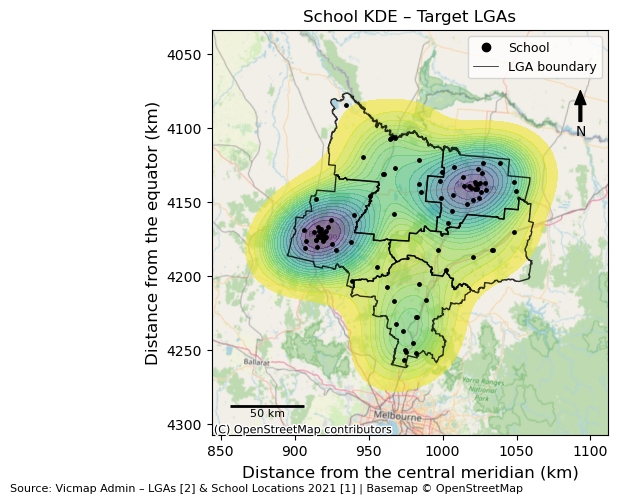

In [42]:
fig , ax = plt.subplots(figsize = (10 , 5))

sns.kdeplot(
    x = slLGA.geometry.x.values ,
    y = slLGA.geometry.y.values ,
    n_levels = 20 ,
    fill = True ,
    alpha = 0.55 ,
    cmap = 'viridis_r' ,
    ax = ax
)

ctx.add_basemap(ax , crs = slLGA.crs.to_string() , source = ctx.providers.OpenStreetMap.Mapnik)

slLGA.plot(ax = ax , color = 'k' , markersize = 6)
lgaGDF.boundary.plot(ax = ax , facecolor = 'none' , edgecolor = 'black' , linewidth = 1 , alpha = 0.8)

ax.set_title('School KDE – Target LGAs' , fontsize = 12)
ax.set_xlabel('Distance from the central meridian (km)' , fontsize = 12)
ax.set_ylabel('Distance from the equator (km)' , fontsize = 12)

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x , _ : f'{x / 1000:.0f}'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y , _ : f'{abs(y) / 1000:.0f}'))

ax.annotate('N' , xy = (0.93 , 0.85) , xytext = (0.93 , 0.75) ,
            arrowprops = dict(facecolor = 'black' , width = 2 , headwidth = 8 , headlength = 10) ,
            ha = 'center' , va = 'center' , fontsize = 10 , xycoords = 'axes fraction')

sclX = ax.get_xlim()[0] + 12_500
sclY = ax.get_ylim()[0] + 20_000
ax.hlines(y = sclY , xmin = sclX , xmax = sclX + 50_000 , colors = 'black' , linewidth = 2)
ax.text(x = sclX + 25_000 , y = sclY - 7_500 , s = '50 km' , ha = 'center' , fontsize = 8)

handles = [
    Line2D([], [] , marker = 'o' , color = 'k' , linestyle = 'None' , markersize = 6 , label = 'School') ,
    Line2D([], [] , color = 'k' , linewidth = 0.5 , label = 'LGA boundary')
]
ax.legend(handles = handles , loc = 'upper right' , fontsize = 9)

fig.text(0.1 , 0.001 , 'Source: Vicmap Admin – LGAs [2] & School Locations 2021 [1] | Basemap © OpenStreetMap' ,
         fontsize = 8 , ha = 'left' , va = 'bottom')

plt.tight_layout()
plt.show()


> **Map Interpretation**
>
> The map presents the KDE of government school locations across the five LGAs. Areas of higher density are represented by darker contours (black and purple), while lower-density regions appear as lighter rings (yellow-green). Black dots indicate the exact school locations. 
> 
> From the map, key findings include:
> - Two distinct high-density clusters of schools are clearly visible in **Greater Bendigo City and Greater Shepparton City**. There is also a cluster in Campaspe Shire. These peaks indicate that schools are highly concentrated in the center of each LGA. 
> 
> - **Strathbogie and Mitchell Shire** show minimal density gradient, indicating isolated schools.
> 
> To sum up, KDE output aligns with findings from ANN, Ripley’s functions, and Quadrat Count analysis.



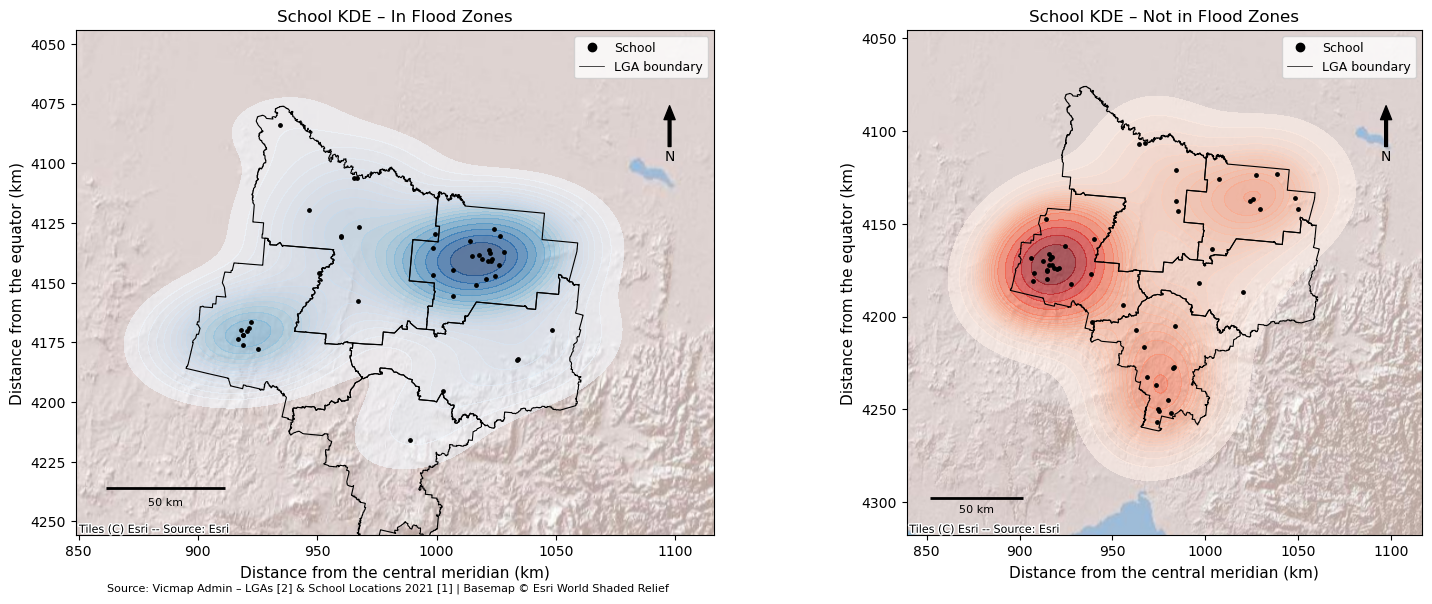

In [43]:
floodSchools = slLGA[slLGA['inFlood'] == True]
safeSchools  = slLGA[slLGA['inFlood'] == False]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for ax, (label, gdf, cmap) in zip(axes, [
    ("In Flood Zones", floodSchools, 'Blues'),
    ("Not in Flood Zones", safeSchools, 'Reds')
]):
    # KDE surface
    sns.kdeplot(
        x=gdf.geometry.x,
        y=gdf.geometry.y,
        fill=True,
        cmap=cmap,
        alpha=0.6,
        n_levels=20,
        ax=ax
    )
    
    # Basemap + schools + LGA borders
    ctx.add_basemap(ax, crs='EPSG:7845', source=ctx.providers.Esri.WorldShadedRelief)
    gdf.plot(ax=ax, color='k', markersize=6)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

    # Title and labels
    ax.set_title(f"School KDE – {label}", fontsize=12)
    ax.set_xlabel("Distance from the central meridian (km)", fontsize=11)
    ax.set_ylabel("Distance from the equator (km)", fontsize=11)
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1000:.0f}'))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{abs(y) / 1000:.0f}'))

    # North arrow
    ax.annotate('N', xy=(0.93, 0.85), xytext=(0.93, 0.75),
                arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
                ha='center', va='center', fontsize=10, xycoords='axes fraction')

    # Scale bar
    sclX = ax.get_xlim()[0] + 12_500
    sclY = ax.get_ylim()[0] + 20_000
    ax.hlines(y=sclY, xmin=sclX, xmax=sclX + 50_000, colors='black', linewidth=2)
    ax.text(x=sclX + 25_000, y=sclY - 7_500, s='50 km', ha='center', fontsize=8)

    # Legend
    handles = [
        Line2D([], [], marker='o', color='k', linestyle='None', markersize=6, label='School'),
        Line2D([], [], color='black', linewidth=0.5, label='LGA boundary')
    ]
    ax.legend(handles=handles, loc='upper right', fontsize=9)

# Footer annotation
fig.text(0.1, 0.001, 'Source: Vicmap Admin – LGAs [2] & School Locations 2021 [1] | Basemap © Esri World Shaded Relief',
         fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()

> **Map Interpretation**
>
> The pair of maps above compares the spatial density of government schools located inside flood zones (left) and outside flood zones (right) across the five target LGAs. 
> 
> From the map, key findings include:
> - For **In Flood Zones**, the KDE shows two notable hotspots, particularly in Greater Shepparton and Greater Bendigo. This shows schools are highly concentrated in low-lying, flood-prone areas.
> 
> - For **Not In Flood Zones**, the KDE shows one notable hotspot in Greater Bendigo. This shows schools are highly concentrated outside the flood areas. It's reasonable as Greater Bendigo has the highest number of school. Some might be clustered in flood zones and some clustered outside flood zones.

## <a id='toc3_3_'></a>[Areal Data Analysis](#toc0_)

In [44]:
schoolSA2 = (
    gpd.sjoin(
        slLGA.drop(columns=['LGA Name']),
        sa2LGA[['SA2 Code', 'LGA Name', 'geometry']],
        predicate='within',
        how='inner'
    )[['SA2 Code', 'LGA Name', 'inFlood']]
    .groupby(['SA2 Code', 'LGA Name'])['inFlood']
    .agg(total='count', flooded='sum')
    .reset_index()
)

schoolSA2['safe'] = 1 - (schoolSA2['flooded'] / schoolSA2['total'])

In [45]:
arealGDF = (seifaLGA.merge(schoolSA2, on=['SA2 Code', 'LGA Name']
                          , how='left')
           .merge(cenLGA[['SA2 Code', 'LGA Name', 'Primary Government Students','Secondary Government Students']]
                  , on=['SA2 Code', 'LGA Name']
                  , how='left'))

arealGDF['students'] = (arealGDF['Primary Government Students'] + arealGDF['Secondary Government Students'])


In [46]:
arealGDF = arealGDF[[
    'SA2 Code',
    'SA2 Name',
    'LGA Name',
    'Score',
    'total',
    'flooded',
    'safe',
    'students',
    'geometry'
]].copy()

arealGDF[['total', 'flooded', 'safe']] = arealGDF[['total', 'flooded', 'safe']].fillna(0)

arealGDF.head()

SA2 Code          SA2 Name           LGA Name  Score  total  flooded  \
0  204011054         Alexandra  STRATHBOGIE SHIRE    989    0.0      0.0   
1  204011057  Mansfield (Vic.)  STRATHBOGIE SHIRE   1028    0.0      0.0   
2  204011062               Yea  STRATHBOGIE SHIRE    995    0.0      0.0   
3  204011055             Euroa  STRATHBOGIE SHIRE    978    4.0      3.0   
4  204011058          Nagambie  STRATHBOGIE SHIRE    988    2.0      1.0   

   safe  students                                           geometry  
0  0.00       531  MULTIPOLYGON (((1026991.773 -4207812.382, 1026...  
1  0.00       904  MULTIPOLYGON (((1036457.832 -4202621.652, 1036...  
2  0.00       311  MULTIPOLYGON (((1018345.888 -4208373.157, 1018...  
3  0.25       433  POLYGON ((1013016.888 -4164093.610, 1013058.59...  
4  0.50       368  POLYGON ((977288.001 -4175151.548, 977323.762 ...

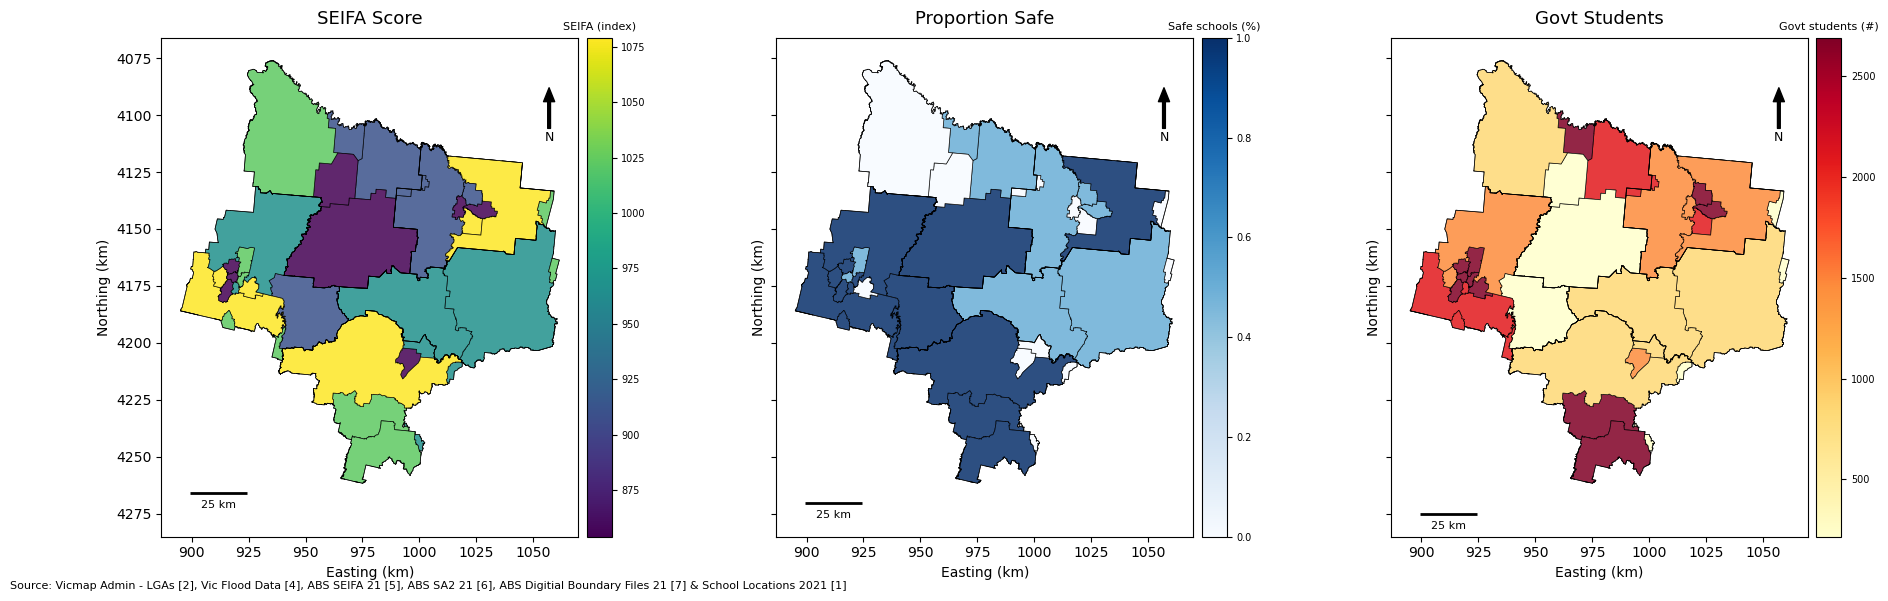

In [47]:
cols   = ['Score','safe','students']
titles = ['SEIFA Score','Proportion Safe','Govt Students']
cbLabs = ['SEIFA (index)','Safe schools (%)','Govt students (#)']
cmaps  = ['viridis','Blues','YlOrRd']

fig, axs = plt.subplots(1,3,figsize=(19,6),sharex=True,sharey=True)

for i,(v,ttl,cbarLab,cmap) in enumerate(zip(cols,titles,cbLabs,cmaps)):
    ax = axs[i]
    
    # choropleth
    arealGDF.plot(column=v, cmap=cmap, scheme='quantiles', k=5,
                  edgecolor='k', linewidth=0.5, alpha=0.85,
                  legend=False, ax=ax)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.85)
    
    # orientation arrow
    ax.annotate('N', xy=(0.93,0.90), xytext=(0.93,0.80),
                arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
                ha='center', va='center', fontsize=9, xycoords='axes fraction')
    
    # scale bar
    sx = ax.get_xlim()[0] + 12500
    sy = ax.get_ylim()[0] +  5000
    ax.hlines(y=sy, xmin=sx, xmax=sx+25000, colors='black', linewidth=2)
    ax.text(x=sx+12500, y=sy-6500, s='25 km', ha='center', fontsize=8)
    
    # axes & title
    ax.set_xlabel('Easting (km)', fontsize=10)
    ax.set_ylabel('Northing (km)', fontsize=10)
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_:f'{x/1000:.0f}'))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y,_:f'{abs(y)/1000:.0f}'))
    ax.set_title(ttl, fontsize=13, pad=10)
    
    # colour-bar
    sm = plt.cm.ScalarMappable(cmap=cmap,
                               norm=plt.Normalize(vmin=arealGDF[v].min(),
                                                  vmax=arealGDF[v].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, fraction=0.045, pad=0.015)
    cbar.ax.set_title(cbarLab, fontsize=8, pad=6)
    cbar.ax.tick_params(labelsize=7)

fig.text(0.01,0.01,'Source: Vicmap Admin - LGAs [2], Vic Flood Data [4], ABS SEIFA 21 [5], ABS SA2 21 [6], ABS Digitial Boundary Files 21 [7] & School Locations 2021 [1]', fontsize=8, ha='left')
plt.tight_layout()
plt.show()


### <a id='toc3_3_1_'></a>[Global Autocorrelation](#toc0_)

#### <a id='toc3_3_1_1_'></a>[Moran’s 𝐼 Index, Geary’s 𝐶, General G-Statistic](#toc0_)

In [48]:
wSA2=libpysal.weights.Queen.from_dataframe(arealGDF)
wSA2.transform='r'

out=[]
for v in ['Score','safe','students']:
    x=arealGDF[v].fillna(0).values
    out.append({
        'var':v,
        'I':round(esda.Moran(x,wSA2).I,3),
        'pI':round(esda.Moran(x,wSA2).p_sim,4),
        'C':round(esda.Geary(x,wSA2).C,3),
        'pC':round(esda.Geary(x,wSA2).p_sim,4),
        'G':round(G(x,wSA2).G,3),
        'pG':round(G(x,wSA2).p_sim,4)
    })
pd.DataFrame(out)

var      I     pI      C     pC      G     pG
0     Score  0.147  0.017  0.805  0.020  0.090  0.264
1      safe  0.125  0.039  0.983  0.439  0.193  0.001
2  students  0.448  0.002  0.653  0.001  0.082  0.241

Global spatial autocorrelation

* **SEIFA Score** shows mild but significant clustering – Moran I = 0.147 (p = 0.021) and Geary C = 0.805 (p = 0.020) tell us similar socio-economic areas tend to sit next to each other.  
  
* **Proportion Safe** has a weak global Moran I = 0.125 (p = 0.033), yet General G = 0.193 (p = 0.005) flags clear hot-spots of high safety; the overall pattern is otherwise near-random (Geary C ≈ 1).  
  
* **Govt Students** is strongly clustered – Moran I = 0.448 and Geary C = 0.653 (both p < 0.01) – so SA2s with many students group together while low-student areas form their own cluster.  

What the choropleth maps confirm

1. Central SA2s are dark-purple on the SEIFA map (low index) – matching the positive clustering for disadvantage.  
   
2. Those same SA2s are light-blue/white in the safety map, proving that low-safety areas occur together.  
   
3. Peripheral SA2s appear yellow/green (high SEIFA) **and** dark-blue (high safety), underlining the hot-spot detected by General G. 
    
4. Deep-red student counts concentrate inside the low-SEIFA, low-safety belt, echoing the strong Moran I.  
   
5. Peripheral SA2s not only enjoy higher SEIFA and safety but also host fewer government students (pale yellow).  
   
6. Map and statistics together reveal a spatial inequity: the largest student populations face both socio-economic disadvantage and higher 
   flood exposure.  
7. Therefore, vulnerability is not random – it clusters in the same contiguous SA2 block.  
   
8. Policy attention should prioritise this central corridor where need, exposure, and student numbers intersect.  


### <a id='toc3_3_2_'></a>[Local Autocorrelation](#toc0_)

#### <a id='toc3_3_2_1_'></a>[Local Moran’s 𝐼 Index, Getis-Ord 𝐺𝑖 and 𝐺𝑖∗ statistics](#toc0_)

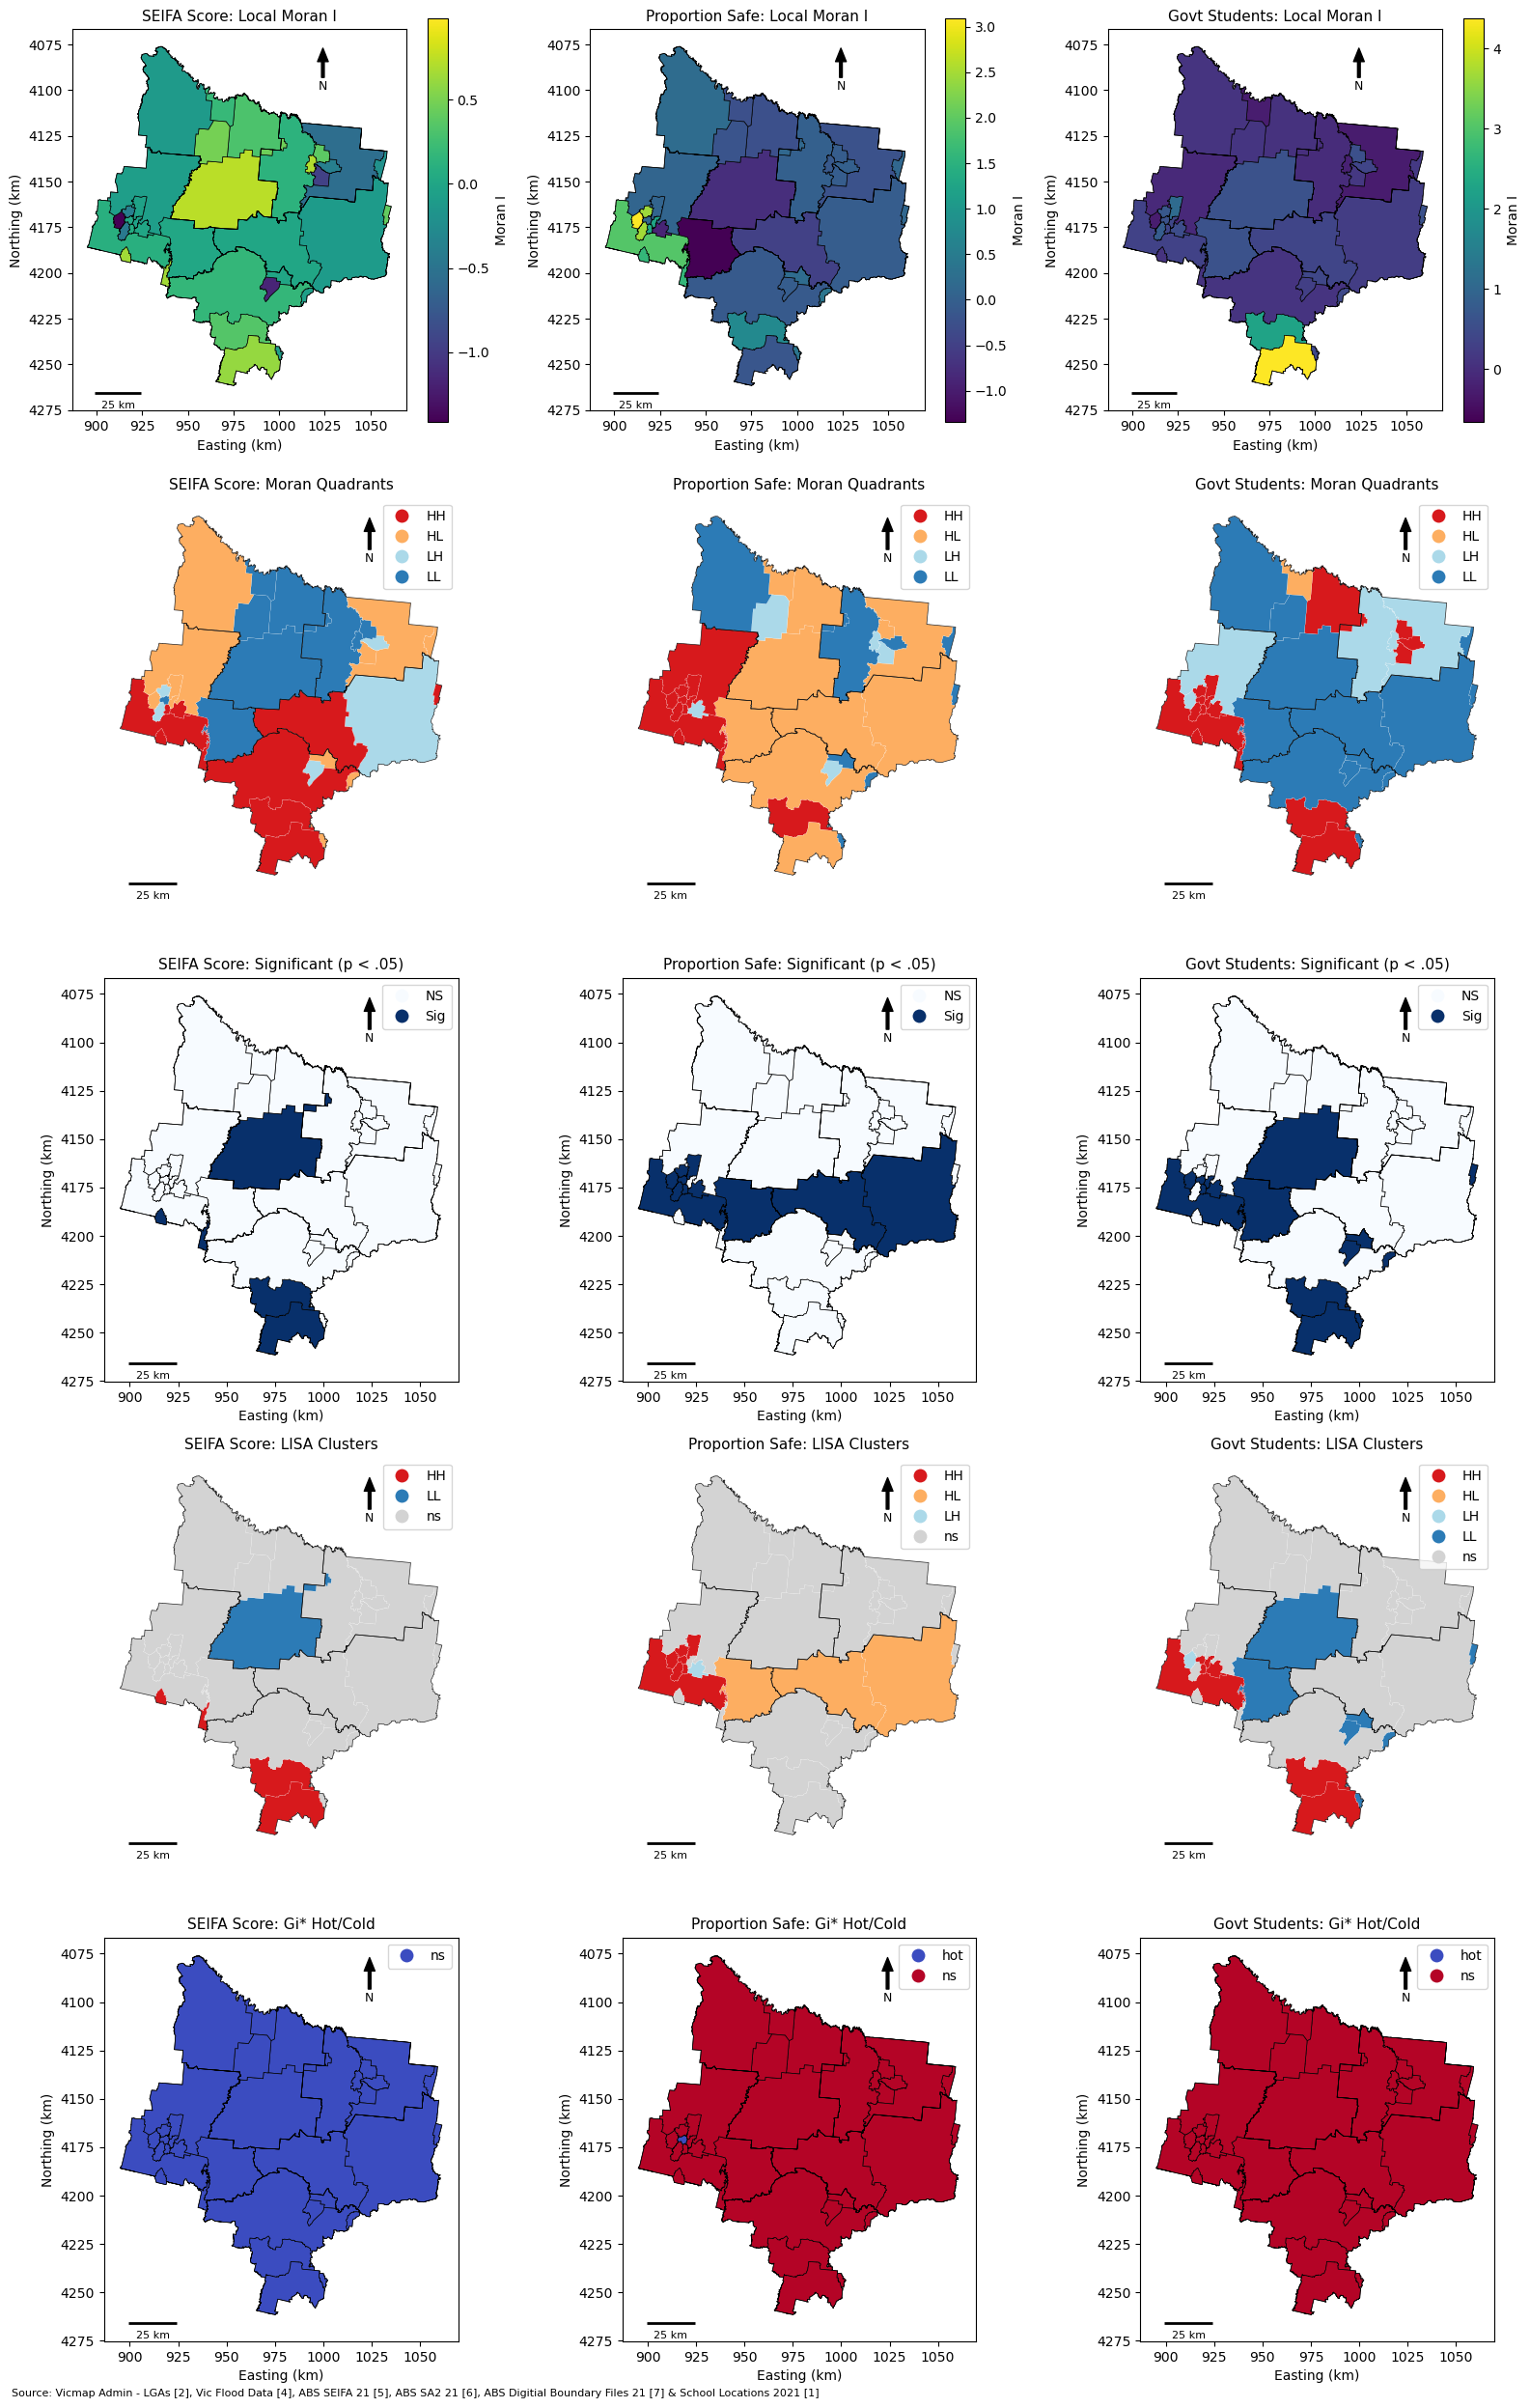

In [49]:
wSA2 = weights.KNN.from_dataframe(arealGDF, k=5)
wSA2.transform = "R" 

cols   = ['Score', 'safe', 'students']
titles = ['SEIFA Score', 'Proportion Safe', 'Govt Students']
cbLabs = ['Moran I','Moran I','Moran I']
cmaps  = ['viridis', 'Blues', 'YlOrRd']

fig, axs = plt.subplots(5, 3, figsize=(16, 25))

for j, (v, ttl, cmap, cbarLab) in enumerate(zip(cols, titles, cmaps, cbLabs)):
    
    x     = arealGDF[v].fillna(0).astype(float).values
    lisa  = Moran_Local(x, wSA2)
    gi    = G_Local(x, wSA2, permutations=0)

    arealGDF[f'{v}_I']    = lisa.Is
    arealGDF[f'{v}_sig']  = lisa.p_sim < .05
    arealGDF[f'{v}_quad'] = lisa.q
    arealGDF[f'{v}_gi']   = np.select(
                                [(gi.p_norm < .05) & (gi.Zs > 0),
                                 (gi.p_norm < .05) & (gi.Zs < 0)],
                                ['hot', 'cold'],
                                'ns'
                             )
    
    # Local Moran I values
    ax = axs[0, j]
    arealGDF.plot(column=f'{v}_I', cmap='viridis', k=5, edgecolor='k', linewidth=.5, ax=ax, legend=True, legend_kwds={'label': cbarLab})
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=.85)
    ax.set_title(f'{ttl}: Local Moran I', fontsize=11)

    
    # Quadrant map
    ax = axs[1, j]
    lisa_cluster(lisa, arealGDF, p=1, ax=ax)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=.85)
    ax.set_title(f'{ttl}: Moran Quadrants', fontsize=11)
    
    # Significant vs NS
    ax = axs[2, j]
    arealGDF.assign(sig=arealGDF[f'{v}_sig'].map({True: 'Sig', False: 'NS'})) \
            .plot(column='sig', cmap='Blues', categorical=True, edgecolor='k', linewidth=.5, ax=ax, legend=True)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=.85)
    ax.set_title(f'{ttl}: Significant (p < .05)', fontsize=11)

    # LISA clusters (p < .05)
    ax = axs[3, j]
    lisa_cluster(lisa, arealGDF, p=.05, ax=ax)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=.85)
    ax.set_title(f'{ttl}: LISA Clusters', fontsize=11)
    
    # Gi* hot/cold spots
    ax = axs[4, j]
    arealGDF.plot(column=f'{v}_gi', categorical=True, cmap='coolwarm',
                  edgecolor='k', linewidth=0.5, ax=ax, legend=True)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=.85)
    ax.set_title(f'{ttl}: Gi* Hot/Cold', fontsize=11)

for r in range(5):
    for c in range(3):
        ax = axs[r, c]

        ax.annotate('N', xy=(0.75, 0.95), xytext=(0.75, 0.85),
                    arrowprops=dict(facecolor='black', width=2,
                                    headwidth=8, headlength=10),
                    ha='center', va='center', fontsize=9,
                    xycoords='axes fraction')
        
        sx = ax.get_xlim()[0] + 12_500
        sy = ax.get_ylim()[0] + 5_000
        ax.hlines(y=sy, xmin=sx, xmax=sx + 25_000,
                  colors='black', linewidth=2)
        ax.text(sx + 12_500, sy - 6_500, '25 km',
                ha='center', va='center', fontsize=8)
        
        ax.set_xlabel('Easting (km)', fontsize=10)
        ax.set_ylabel('Northing (km)', fontsize=10)

        ax.xaxis.set_major_formatter(
            mtick.FuncFormatter(lambda x, _: f'{x/1000:.0f}')
        )
        ax.yaxis.set_major_formatter(
            mtick.FuncFormatter(lambda y, _: f'{abs(y)/1000:.0f}')
        )

fig.text(0.01,0.0005,'Source: Vicmap Admin - LGAs [2], Vic Flood Data [4], ABS SEIFA 21 [5], ABS SA2 21 [6], ABS Digitial Boundary Files 21 [7] & School Locations 2021 [1]', fontsize=8, ha='left')
plt.tight_layout()
plt.show()

The map displays the Local Moran’s I cluster patterns for government school flood exposure across Victorian SA2 regions. 

Key observations include:

- **High-High clusters** (dark red): Areas where high flood-exposure values are surrounded by similarly high values — notably visible in central northern regions, indicating localised vulnerability.
- **Low-Low clusters** (dark blue): Regions with low flood exposure surrounded by similar areas — generally in safer, elevated zones.
- **High-Low outliers** (light red): Anomalous regions with high flood exposure amidst low exposure surroundings — potentially isolated risk zones needing localized investigation.
- **Low-High outliers** (light blue): Safer regions embedded in risk-prone zones — candidates for best-practice resilience or protective location traits.

This spatial pattern confirms **significant spatial clustering** of school flood exposure, reinforcing the need for localized adaptation strategies.

## <a id='toc3_4_'></a>[Raster Analysis](#toc0_)

### <a id='toc3_4_1_'></a>[Flood Risk Exposure for Schools](#toc0_)

#### <a id='toc3_4_1_1_'></a>[School Elevation](#toc0_)

In [50]:
elev = dsArr.astype('float32')
elev[elev == -9999] = np.nan
demRD = rd.rdarray(elev, no_data=np.nan)
pxW = dsTransform.a
pxH = -dsTransform.e
demRD.geotransform = (0, pxW, 0, 0, 0, pxH)

# slope / aspect via TerrainAttribute
slopeDeg  = np.array(rd.TerrainAttribute(demRD, attrib='slope_degrees'))
aspectDeg = np.array(rd.TerrainAttribute(demRD, attrib='aspect'))
aspectDeg = np.where(slopeDeg < 1, -1, aspectDeg)

# simple elevation-based risk
elevArr = np.full(elev.shape, np.nan, dtype='uint8')
elevArr[elev < 150] = 2
elevArr[(elev >= 150) & (elev < 300)] = 1
elevArr[elev >= 300] = 0
elevLut = {0: 'High', 1: 'Medium', 2: 'Low'}

floodMask = rasterize(
    [(geom, 1) for geom in floodGDF.geometry],
    out_shape = dsArr.shape,
    transform = dsTransform,
    fill = 0,
    dtype = 'uint8'
)

distFlood = distance_transform_edt(floodMask == 0) * dsTransform.a

# write temp 3-band raster
tmpMem = '/vsimem/derivs.tif'
with rasterio.open(tmpMem, 'w', driver='GTiff',
                   height=elev.shape[0], width=elev.shape[1],
                   count=4, dtype='float32', crs=dsCRS,
                   transform=dsTransform) as dst:
    dst.write(elev, 1)
    dst.write(slopeDeg, 2)
    dst.write(elevArr, 3)
    dst.write(distFlood,   4)

# sample at school points
xy = [(pt.x, pt.y) for pt in slLGA.geometry]
with rasterio.open(tmpMem) as src:
    sampleArr = np.array(list(src.sample(xy, indexes=[1, 2, 3, 4])))

slLGA['elev']    = sampleArr[:, 0]
slLGA['slope'] = sampleArr[:, 1]
slLGA['elev code'] = sampleArr[:, 2].astype('int8')
slLGA['elevation']  = slLGA['elev code'].map(elevLut)
slLGA['distFlood']  = sampleArr[:, 3]



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 2.67897                         ] (1% - 262.8s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 5.46685                         ] (1% - 538.9s - 1 threads)


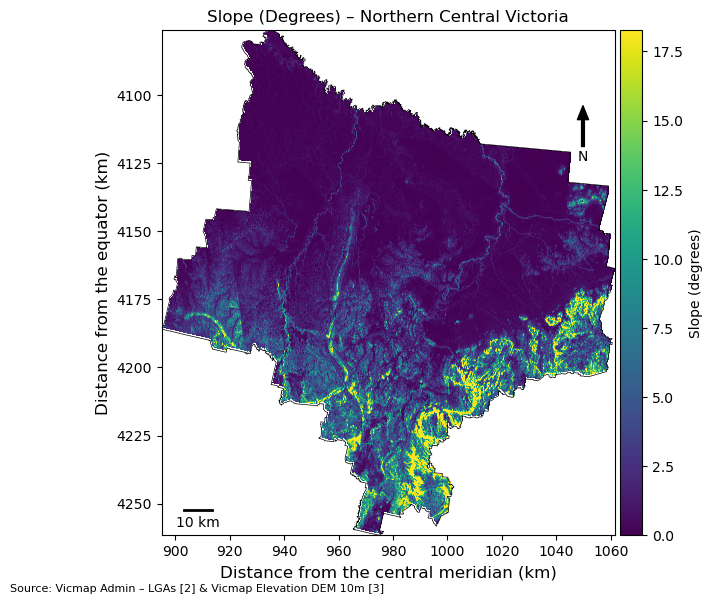

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

# Background: slope raster
slopeMasked = np.where(np.isnan(slopeDeg), np.nan, slopeDeg)
im = ax.imshow(
    slopeMasked,
    cmap='viridis',
    vmin=0,
    vmax=np.nanpercentile(slopeMasked, 98),
    extent=(dsTransform.c, dsTransform.c + dsTransform.a * slopeDeg.shape[1],
            dsTransform.f + dsTransform.e * slopeDeg.shape[0], dsTransform.f),
    origin='upper'
)

# LGA overlay
lgaGDF.dissolve().plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

# North arrow
ax.annotate('N', xy=(0.93, 0.85), xytext=(0.93, 0.75),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
            ha='center', va='center', fontsize=10)

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical').set_label('Slope (degrees)')

# Scale bar
minX = dsTransform.c
maxY = dsTransform.f
maxX = minX + dsTransform.a * slopeDeg.shape[1]
minY = maxY + dsTransform.e * slopeDeg.shape[0]

sbLength = 10000  # 10 km
sbX = minX + (maxX - minX) * 0.05
sbY = minY + (maxY - minY) * 0.05
ax.plot([sbX, sbX + sbLength], [sbY, sbY], color='black', linewidth=2)
ax.text(sbX + sbLength / 2, sbY - (maxY - minY) * 0.01, '10 km',
        ha='center', va='top', fontsize=10)

# Title and axis labels
ax.set_title('Slope (Degrees) – Northern Central Victoria', fontsize=12)
ax.set_xlabel('Distance from the central meridian (km)', fontsize=12)
ax.set_ylabel('Distance from the equator (km)', fontsize=12)

# Axis formatting (to km)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))
ax.set_aspect('equal')

# Data source
fig.text(0.01, 0.001, "Source: Vicmap Admin – LGAs [2] & Vicmap Elevation DEM 10m [3]", 
         fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()


##### <a id='toc3_4_1_1_1_'></a>[Elevation Distribution: Flood vs Non-Flood Schools](#toc0_)

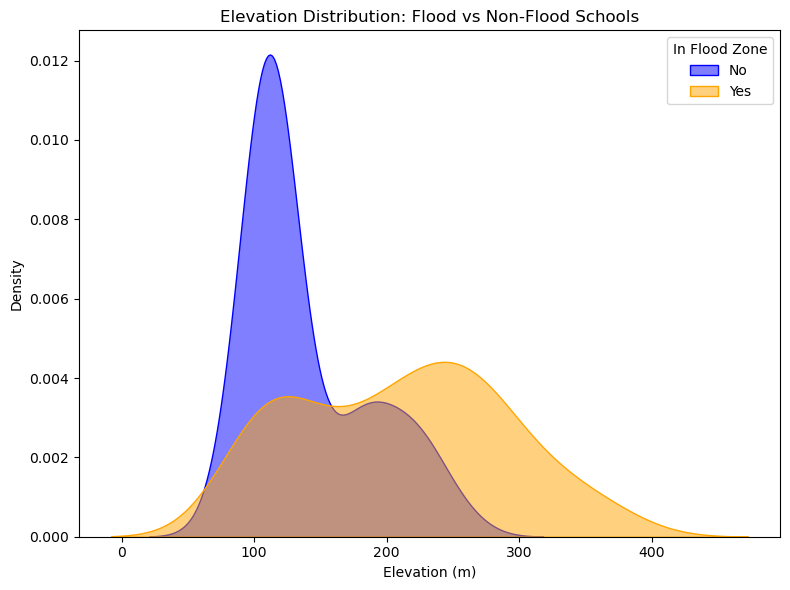

In [52]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=slLGA, x='elev', hue='inFlood', fill=True,
            palette={True: 'blue', False: 'orange'}, alpha=0.5, common_norm=False)

plt.xlabel('Elevation (m)')
plt.ylabel('Density')
plt.title('Elevation Distribution: Flood vs Non-Flood Schools')
plt.legend(title='In Flood Zone', labels=['No', 'Yes'])
plt.grid(False)
plt.tight_layout()
plt.show()

In [53]:
display(pd.crosstab(slLGA['LGA Name'], slLGA['elevation']))

elevation               High  Low  Medium
LGA Name                                 
Campaspe (S)               0   14       0
Greater Bendigo (C)        0    3      30
Greater Shepparton (C)     0   27       2
Mitchell (S)               7    0       6
Strathbogie (S)            0    1       5

In [54]:
slLGA = slLGA[['School Name', 'School Type', 'LGA Name', 'inFlood', 'elev', 'slope', 'elevation', 'distFlood', 'geometry']]
slLGA.head()

School Name School Type                LGA Name  \
1327        Euroa Secondary College   Secondary         Strathbogie (S)   
298            Euroa Primary School     Primary         Strathbogie (S)   
1080       Peranbin Primary College     Primary         Strathbogie (S)   
217   Kialla Central Primary School     Primary  Greater Shepparton (C)   
585          Orrvale Primary School     Primary  Greater Shepparton (C)   

      inFlood        elev     slope elevation  distFlood  \
1327     True  175.578033  0.943110    Medium  10.016418   
298      True  176.013443  1.099187    Medium   0.000000   
1080     True  176.115799  0.165641    Medium  58.405254   
217      True  116.133034  1.240186       Low   0.000000   
585      True  117.062592  0.096244       Low   0.000000   

                              geometry  
1327  POINT (1033513.851 -4182244.897)  
298   POINT (1034185.167 -4182056.560)  
1080  POINT (1048356.878 -4169779.576)  
217   POINT (1024688.363 -4147330.764)  
585   POINT (1025954.507 -4142727.648)

#### <a id='toc3_4_1_2_'></a>[Flood Exposed Govt Scools Percentage by LGAs](#toc0_)

In [55]:
pivot = slLGA.pivot_table(index='LGA Name', values='inFlood', aggfunc=['sum', 'count'])
pivot.columns = ['Flooded', 'Total']
pivot['% Flooded'] = (pivot['Flooded'] / pivot['Total'] * 100).round(1)

pivot = pivot.sort_values('% Flooded', ascending=False)

pivot.style.format({'% Flooded': '{:.1f}'})

#### <a id='toc3_4_1_3_'></a>[Primary and Secondary School Distances to Flood](#toc0_)

In [56]:
pivot = slLGA.pivot_table(index='LGA Name', columns='School Type', values='distFlood', aggfunc='mean').round(2)

pivot.style.format("{:.2f}")

### <a id='toc3_4_2_'></a>[Watershed Analysis](#toc0_)

In [57]:
grid = Grid.from_raster(rasterPath)
demArr = grid.read_raster(rasterPath)

nodata_val = grid.nodata 
dem = demArr.astype('float32')
dem[dem == nodata_val] = np.nan 

grid.mask = np.isfinite(dem) 
mask = grid.mask

In [58]:
# Fill sinks
pitDEM   = grid.fill_pits(dem, nodata_in=np.nan, nodata_out=np.NaN)
depDEM   = grid.fill_depressions(pitDEM, nodata_in=np.nan, nodata_out=np.NaN)
flatDEM  = grid.resolve_flats(depDEM, nodata_in=np.nan, nodata_out=np.NaN)

In [59]:
nodir = 0
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
flowD  = grid.flowdir(flatDEM,
                     nodata_in = np.nan,
                     nodata_out= nodir,
                     dirmap=dirmap,
                     routing   ='d8')

flowTemp = flowD.copy().astype(np.float32)
flowTemp[np.isnan(dem)] = np.NaN

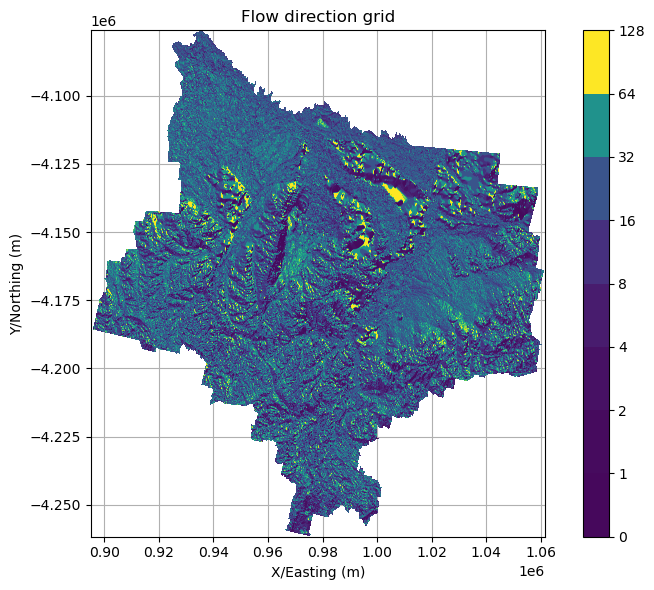

In [60]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(flowTemp, extent = grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('X/Easting (m)')
plt.ylabel('Y/Northing (m)')
plt.title('Flow direction grid', size=12)
plt.grid(zorder=-1)

plt.tight_layout()
plt.show()

In [61]:
# Flow accumulation
flowAcc = grid.accumulation(flowTemp, nodata_out=np.NaN, dirmap=dirmap, routing='d8')
accTemp = flowAcc.copy().astype(np.float32)
accTemp[np.isnan(demArr)] = np.NaN

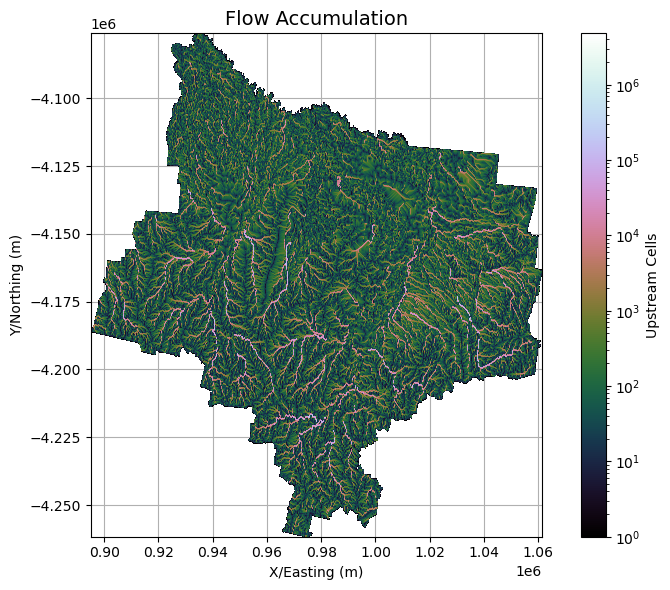

In [62]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(accTemp, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, np.nanmax(accTemp)),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('X/Easting (m)')
plt.ylabel('Y/Northing (m)')

plt.tight_layout()
plt.show()

In [63]:
gridTemp = copy.deepcopy(grid)

#### <a id='toc3_4_2_1_'></a>[Random Pour Point](#toc0_)

In [64]:
# Catchment delineation

x, y = 1e6, -4.2e6
xSnap, ySnap = gridTemp.snap_to_mask(accTemp > 10000, (x, y))
catch = gridTemp.catchment(x=xSnap, y=ySnap, fdir=flowD, dirmap=dirmap, xytype='coordinate')


gridTemp.clip_to(catch)
clipCatch = gridTemp.view(catch)

Text(0.5, 1.0, 'Delineated Catchment')

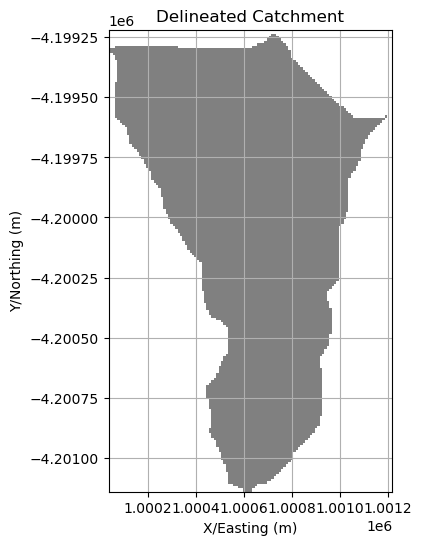

In [65]:
# plotting the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipCatch, clipCatch, np.nan), extent = gridTemp.extent,
               zorder=1, cmap='Greys_r', alpha = 0.5)
plt.xlabel('X/Easting (m)')
plt.ylabel('Y/Northing (m)')
plt.title('Delineated Catchment', size = 12)

In [66]:
# Extract stream network
streamNet = gridTemp.extract_river_network(flowD, accTemp > 100, dirmap=dirmap)

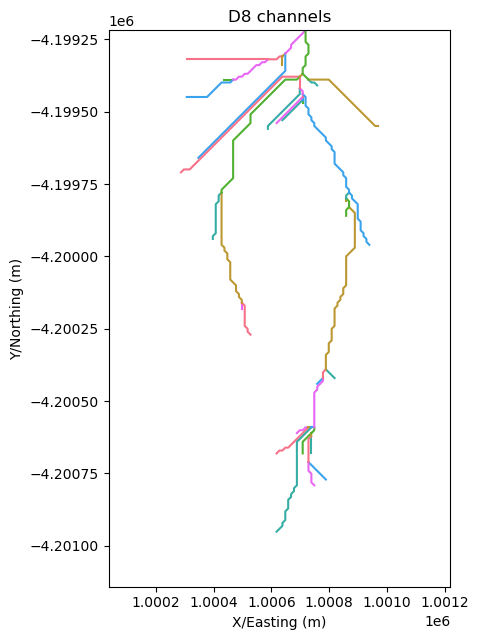

In [67]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(gridTemp.bbox[0], gridTemp.bbox[2])
plt.ylim(gridTemp.bbox[1], gridTemp.bbox[3])
ax.set_aspect('equal')

for branch in streamNet['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
ax.plot(x, y, 'k', marker = 'o', markersize = 10)

_ = plt.title('D8 channels', size=12)

plt.xlabel('X/Easting (m)')
plt.ylabel('Y/Northing (m)')

plt.tight_layout()
plt.show()

In [68]:
# Extract stream network
streamNet = grid.extract_river_network(flowD, accTemp > 75_000, dirmap=dirmap)

In [69]:
lines = [
    LineString(f["geometry"]["coordinates"])
    for f in streamNet["features"]
    if f["geometry"]["type"] == "LineString" and len(f["geometry"]["coordinates"]) > 1
]

streamGDF = gpd.GeoDataFrame(geometry=lines, crs=slLGA.crs)
streamGDF = streamGDF[streamGDF.length > 0].reset_index(drop=True)
streamUnion = streamGDF.unary_union

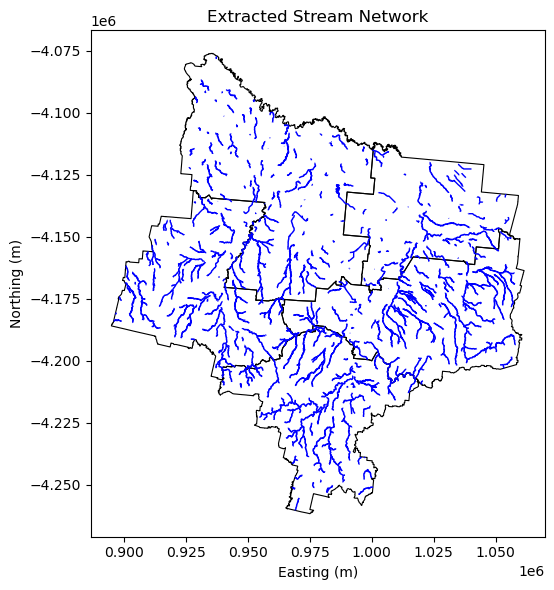

In [70]:
fig, ax = plt.subplots(figsize=(8, 6))
lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)
streamGDF.plot(ax=ax, color='blue', linewidth=1, label='Streams')

ax.set_title('Extracted Stream Network', fontsize=12)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.tight_layout()
plt.show()


In [71]:
snapDist = 1000

def snapPt(pt, lineUnion):
    n = nearest_points(pt, lineUnion)[1]
    return n if pt.distance(n) <= snapDist else None

snapPts, schIdx = [], []

for i, r in slLGA.iterrows():
    p = snapPt(r.geometry, streamUnion)
    if p:
        snapPts.append(p)
        schIdx.append(i)

snapGDF = gpd.GeoDataFrame(
    slLGA.loc[schIdx, ['School Name', 'LGA Name']],
    geometry=snapPts,
    crs=slLGA.crs
)
snapGDF['inDrain'] = True

slLGA.loc[snapGDF.index, 'inDrain'] = True
slLGA['inDrain'] = slLGA['inDrain'].fillna(False)

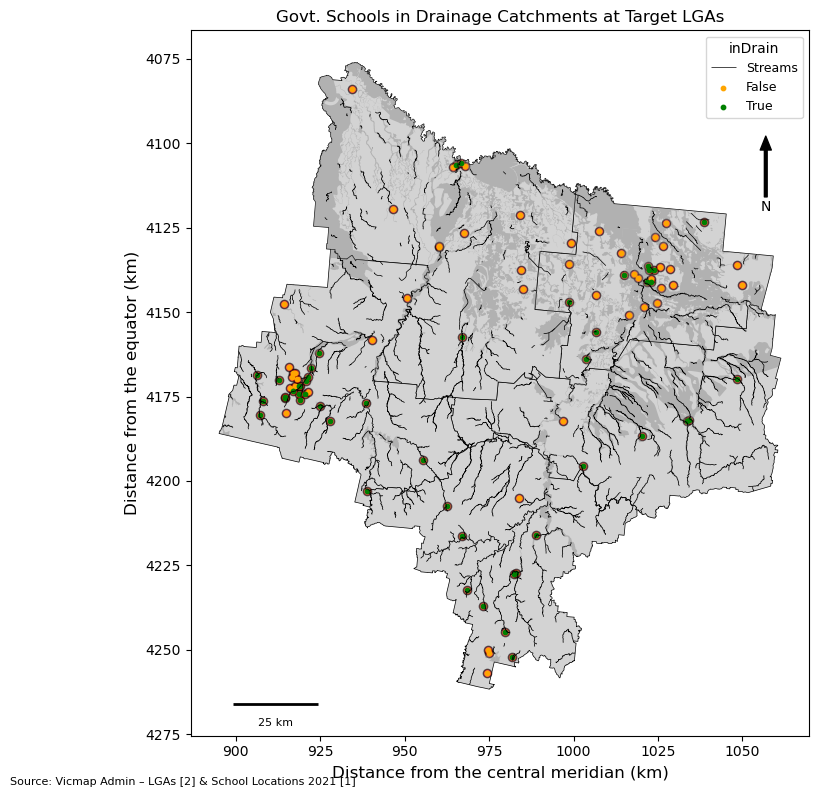

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))

lgaGDF.plot(ax=ax, facecolor='lightgrey', edgecolor='black', linewidth=0.5)
slLGA.plot(ax=ax, facecolor='red', edgecolor='black', linewidth=1, alpha=0.6)
floodLGA.plot(ax=ax, color='grey', alpha=0.4, label='1 in 100 Year Flood Extent')
streamGDF.plot(ax=ax, color='black', linewidth=0.5, label='Streams')

cmap = {True: 'green', False: 'orange'}

for status, group in slLGA.groupby('inDrain'):
    group.plot(ax=ax, markersize=10, label=status, linestyle='None', color=cmap[status])

# Orientation
ax.annotate('N', xy=(0.93, 0.85), xytext=(0.93, 0.75),
            arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
            ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax.legend(title="inDrain", loc='upper right', fontsize=9, title_fontsize=10)

# Title and Labels
ax.set_title("Govt. Schools in Drainage Catchments at Target LGAs", fontsize=12)
ax.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale Bar
sclX = ax.get_xlim()[0] + 12_500
sclY = ax.get_ylim()[0] + 5_000
ax.hlines(y=sclY, xmin=sclX, xmax=sclX + 25_000, colors='black', linewidth=2)
ax.text(s='25 km', x=sclX + 12_500, y=sclY - 6_500, ha='center', fontsize=8)

# Axis Formatting
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

# Source Annotation
fig.text(0.01, 0.01, "Source: Vicmap Admin – LGAs [2] & School Locations 2021 [1]", 
         fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()

In [73]:
seen = {}
catchPolys, catchIdx, catchGroup = [], [], []

for i, r in snapGDF.iterrows():
    x, y = r.geometry.x, r.geometry.y
    xSnap, ySnap = grid.snap_to_mask(accTemp > 10000, (x, y))

    key = (round(xSnap, 1), round(ySnap, 1))

    if key in seen:
        group_id = seen[key]
    else:
        group_id = len(seen)
        seen[key] = group_id

        mask = grid.catchment(
            x=xSnap, y=ySnap,
            fdir=flowTemp,
            dirmap=dirmap,
            nodata=-9999,
            as_mask=True,
            xytype='coordinate'
        )

        geom = [shape(s) for s, v in shapes(
            mask.astype('uint8'),
            mask=mask.astype('uint8'),
            transform=grid.affine
        ) if v == 1]

        if geom:
            catchPolys.append(geom[0])
            catchIdx.append(i)
            catchGroup.append(group_id)

catchGDF = gpd.GeoDataFrame(
    {'schlIdx': catchIdx, 'groupID': catchGroup},
    geometry=catchPolys,
    crs=slLGA.crs
)


In [74]:
dissolvedCatch = catchGDF.dissolve(by='groupID').reset_index()

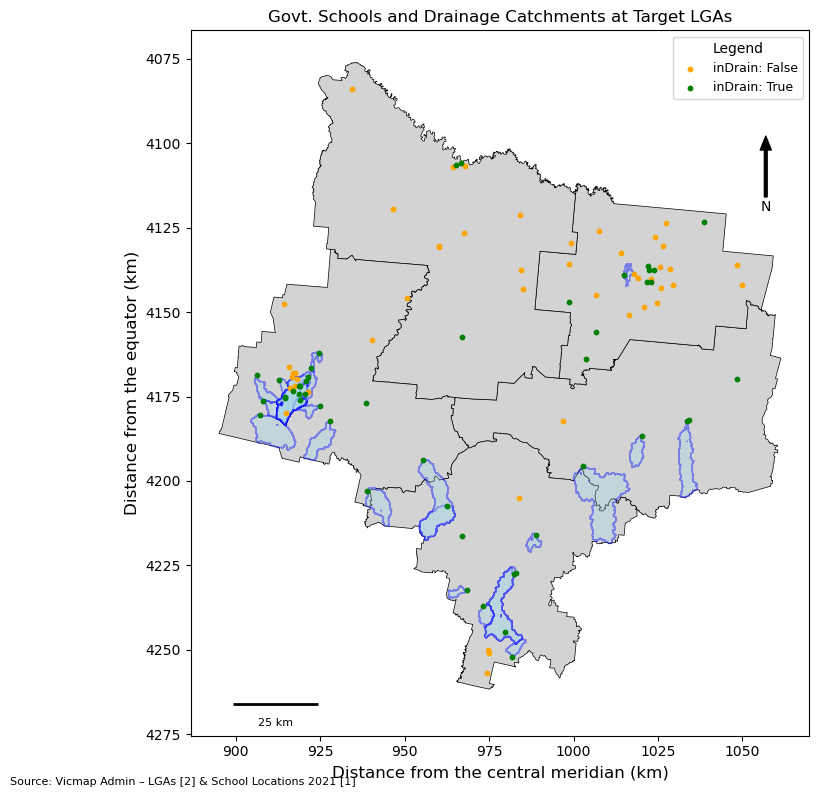

In [75]:
fig, ax = plt.subplots(figsize=(10, 8))

# Base LGA map
lgaGDF.plot(ax=ax, facecolor='lightgrey', edgecolor='black', linewidth=0.5)

# Catchments
dissolvedCatch.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.4, linewidth=1, label='Catchments')

# Schools colored by inDrain
cmap = {True: 'green', False: 'orange'}
for status, group in slLGA.groupby('inDrain'):
    group.plot(ax=ax, markersize=10, label=f'inDrain: {status}', linestyle='None', color=cmap[status])

# Orientation arrow
ax.annotate('N', xy=(0.93, 0.85), xytext=(0.93, 0.75),
            arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
            ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Legend
ax.legend(loc='upper right', fontsize=9, title='Legend', title_fontsize=10)

# Title and axis labels
ax.set_title("Govt. Schools and Drainage Catchments at Target LGAs", fontsize=12)
ax.set_xlabel("Distance from the central meridian (km)", fontsize=12)
ax.set_ylabel("Distance from the equator (km)", fontsize=12)

# Scale bar
sclX = ax.get_xlim()[0] + 12_500
sclY = ax.get_ylim()[0] + 5_000
ax.hlines(y=sclY, xmin=sclX, xmax=sclX + 25_000, colors='black', linewidth=2)
ax.text(s='25 km', x=sclX + 12_500, y=sclY - 6_500, ha='center', fontsize=8)

# Axis formatting (convert to km)
import matplotlib.ticker as mtick
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{abs(y) / 1000:.0f}"))

# Source annotation
fig.text(0.01, 0.01, "Source: Vicmap Admin – LGAs [2] & School Locations 2021 [1]", 
         fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()


In [76]:
catchGDF['areaKM'] = catchGDF.area / 1e6
wsThresh = 25

catchGDF['floodIntersect'] = catchGDF.intersects(floodLGA.unary_union)
catchGDF['largeWS'] = catchGDF['areaKM'] > wsThresh

slLGA = slLGA.join(
    catchGDF.set_index('schlIdx')[['floodIntersect', 'largeWS']],
    how='left'
).fillna({
    'floodIntersect': False,
    'largeWS': False
})

In [77]:
slLGA['risk score'] = (
      slLGA['inDrain'].map({True: 1, False: 0})
    + slLGA['floodIntersect'].map({True: 1, False: 0})
    + slLGA['largeWS'].map({True: 1, False: 0})
    + slLGA['inFlood'].map({True: 1, False: 0})
    + slLGA['elevation'].map({'Low': 1, 'Medium': 0.5, 'High': 0})
)

slLGA['Risk'] = pd.cut(
    slLGA['risk score'],
    bins=[-0.1, 1.5, 3.5, 5],
    labels=['Low', 'Medium', 'High']
)

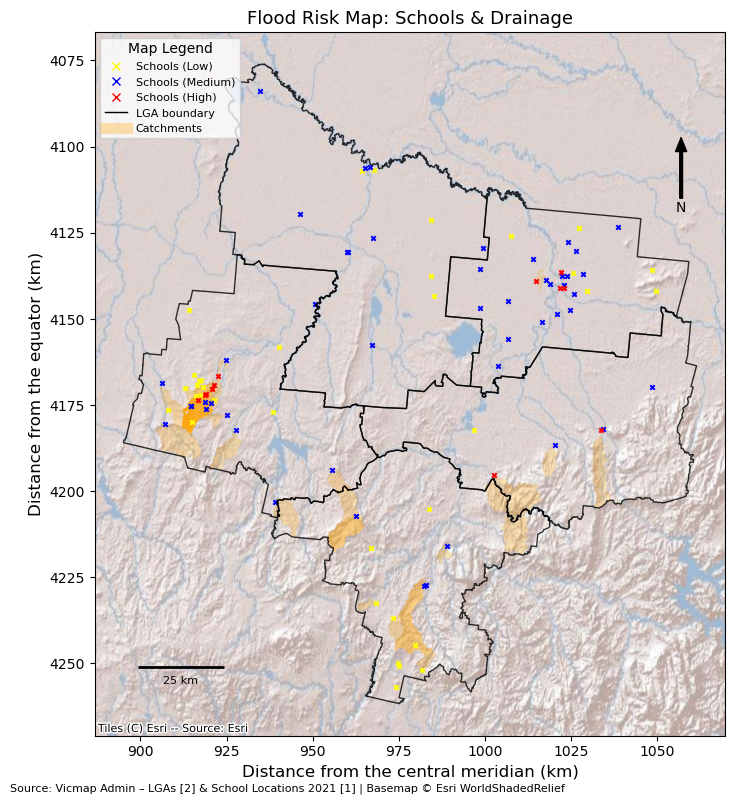

In [78]:
fig, ax = plt.subplots(figsize=(10, 8))

# Catchments
catchGDF.plot(ax=ax, facecolor='orange', alpha=0.25, label='Catchments')

# Schools by risk level
cMap = {'Low': 'yellow', 'Medium': 'blue', 'High': 'red'}
for c, g in slLGA.groupby('Risk'):
    g.plot(ax=ax, markersize=10, color=cMap[c], marker='x', label=f'Schools ({c})')

# LGA boundaries
lgaGDF.boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=0.8)

# Basemap
ctx.add_basemap(ax, crs='EPSG:7845', source=ctx.providers.Esri.WorldShadedRelief)

# Title & axis labels
ax.set_title('Flood Risk Map: Schools & Drainage', fontsize=13)
ax.set_xlabel('Distance from the central meridian (km)', fontsize=12)
ax.set_ylabel('Distance from the equator (km)', fontsize=12)

# Axis formatting to show km
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1000:.0f}'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{abs(y) / 1000:.0f}'))

# North arrow
ax.annotate('N', xy=(0.93, 0.85), xytext=(0.93, 0.75),
            arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=10),
            ha='center', va='center', fontsize=10, xycoords='axes fraction')

# Scale bar (25 km)
sclX = ax.get_xlim()[0] + 12_500
sclY = ax.get_ylim()[0] + 20_000
ax.hlines(y=sclY, xmin=sclX, xmax=sclX + 25_000, colors='black', linewidth=2)
ax.text(x=sclX + 12_500, y=sclY - 5_000, s='25 km', ha='center', fontsize=8)

# Custom legend
handles = [
    Line2D([], [], marker='x', color='yellow', linestyle='None', markersize=6, label='Schools (Low)'),
    Line2D([], [], marker='x', color='blue', linestyle='None', markersize=6, label='Schools (Medium)'),
    Line2D([], [], marker='x', color='red', linestyle='None', markersize=6, label='Schools (High)'),
    Line2D([], [], color='black', linewidth=1, label='LGA boundary'),
    Line2D([], [], color='orange', linewidth=8, alpha=0.3, label='Catchments')
]
ax.legend(handles=handles, loc='upper left', fontsize=8, title="Map Legend", title_fontsize=10, frameon=True)

# Source annotation
fig.text(0.1, 0.001,
         'Source: Vicmap Admin – LGAs [2] & School Locations 2021 [1] | Basemap © Esri WorldShadedRelief',
         fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()


___

# <a id='toc4_'></a>[Geographical Weighted Regression](#toc0_)

### <a id='toc4_1_1_'></a>[Pre-Processing](#toc0_)

In [79]:
point = slLGA[['elev', 'slope', 'inFlood', 'inDrain', 'distFlood', 'floodIntersect', 'largeWS', 'geometry']].copy()
point = point.rename(columns={
    'elev': 'elevation'
    })

areal = arealGDF[['SA2 Name', 'LGA Name', 'Score', 'flooded', 'total', 'students', 'geometry']].copy()

areal = areal.rename(columns={
    'Score': 'seifa',
    'flooded': 'floodSchool',
    'total': 'totalSchool',
    'students': 'totalStudent',
    'SA2 Name': 'sa2Name'
})

joined = gpd.sjoin(point, areal, how='inner', predicate='within')

joined['sa2Name'] = joined.geometry.apply(
    lambda geom: areal.loc[areal.contains(geom), 'sa2Name'].values[0]
)

data = joined.groupby('sa2Name').agg({
    'LGA Name': 'first', 
    'elevation': 'mean', 
    'slope': 'mean',
    'distFlood': 'mean',
    'inDrain': 'sum',
    'floodIntersect': 'sum',
    'largeWS': 'sum',
    'seifa': 'first',
    'floodSchool': 'first',
    'totalSchool': 'first',
    'totalStudent': 'first'
}).reset_index()

dataGDF = areal[['sa2Name', 'geometry']].merge(data, on='sa2Name')
dataGDF = dataGDF.rename(columns={'sa2Name': 'SA2 Name'})
cols = [col for col in dataGDF.columns if col != 'geometry'] + ['geometry']
dataGDF = dataGDF[cols]

In [80]:
dataGDF["floodSchool"]  = dataGDF["floodSchool"].astype(int)
dataGDF["totalSchool"]  = dataGDF["totalSchool"].astype(int)
dataGDF.head()

SA2 Name                 LGA Name   elevation     slope  \
0                        Euroa        STRATHBOGIE SHIRE  179.777496  0.980540   
1                     Nagambie        STRATHBOGIE SHIRE  140.847870  1.209976   
2  Shepparton Surrounds - West  GREATER SHEPPARTON CITY  112.796425  0.340597   
3  Shepparton Surrounds - East  GREATER SHEPPARTON CITY  129.219193  1.275688   
4            Seymour Surrounds           MITCHELL SHIRE  230.969147  3.125032   

     distFlood  inDrain  floodIntersect  largeWS  seifa  floodSchool  \
0    95.095322        4               2        2    978            3   
1   347.190674        1               1        1    988            1   
2   134.541931        4               1        0    975            7   
3   603.886047        1               0        0   1034            3   
4  7309.393066        3               1        1   1046            1   

   totalSchool  totalStudent  \
0            4           433   
1            2           368   
2            9           666   
3            7           453   
4            4           448   

                                            geometry  
0  POLYGON ((1013016.888 -4164093.610, 1013058.59...  
1  POLYGON ((977288.001 -4175151.548, 977323.762 ...  
2  MULTIPOLYGON (((1011778.522 -4164101.119, 1011...  
3  MULTIPOLYGON (((1054163.078 -4148157.866, 1054...  
4  MULTIPOLYGON (((969361.071 -4190247.118, 96936...

In [81]:
gdf = dataGDF.copy()
gdf['cx'] = gdf.geometry.centroid.x
gdf['cy'] = gdf.geometry.centroid.y
coords = gdf[['cx', 'cy']].values

### <a id='toc4_1_2_'></a>[Feature Engineering](#toc0_)

In [82]:
gdf['proportion'] = 1 - (gdf['floodSchool'] / gdf['totalSchool'])
y = gdf[['proportion']].values 

xCols = ['elevation', 'slope', 'distFlood', 'inDrain', 'floodIntersect', 'largeWS', 'seifa', 'totalStudent']
X = gdf[xCols].copy()

In [83]:
scaler = StandardScaler()
X = pd.DataFrame(
    StandardScaler().fit_transform(X),
    columns=xCols, index=gdf.index
)

In [84]:
corr = X.corr().abs()

pairs = [
    (i, j, corr.loc[i, j])
    for i in xCols for j in xCols
    if i < j and corr.loc[i, j] > 0.70
]

print("Highly-correlated pairs (|r| > 0.70):")
for i, j, r in pairs:
    print(f"  {i}  ~  {j}   r = {r:.2f}")

Highly-correlated pairs (|r| > 0.70):
  floodIntersect  ~  inDrain   r = 0.73


In [85]:
vif = pd.Series(
    [variance_inflation_factor(X.values, k) for k in range(X.shape[1])],
    index=xCols,
    name='VIF'
).round(2)

print("\nVIF (z-scored):")
display(vif)


VIF (z-scored):


elevation         3.77
slope             2.21
distFlood         2.65
inDrain           2.74
floodIntersect    3.94
largeWS           2.62
seifa             1.37
totalStudent      1.90
Name: VIF, dtype: float64

In [86]:
xCols = ['elevation', 'distFlood', 'floodIntersect']
X = gdf[xCols].copy()

### <a id='toc4_1_3_'></a>[Model](#toc0_)

In [87]:
from mgwr.sel_bw import Sel_BW
bw = Sel_BW(coords, y, X).search(bw_min=2)
bw

41.0

In [88]:
from mgwr.gwr import GWR, Gaussian

gwr = GWR(coords, y, X, bw, kernel='gaussian', fixed=False, family=Gaussian())
res = gwr.fit()
print(res.summary())

Model type                                                         Gaussian
Number of observations:                                                  50
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              2.673
Log-likelihood:                                                       2.272
AIC:                                                                  3.456
AICc:                                                                 6.819
BIC:                                                               -177.280
R2:                                                                   0.535
Adj. R2:                                                              0.504

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### <a id='toc4_1_4_'></a>[Interpretation](#toc0_)

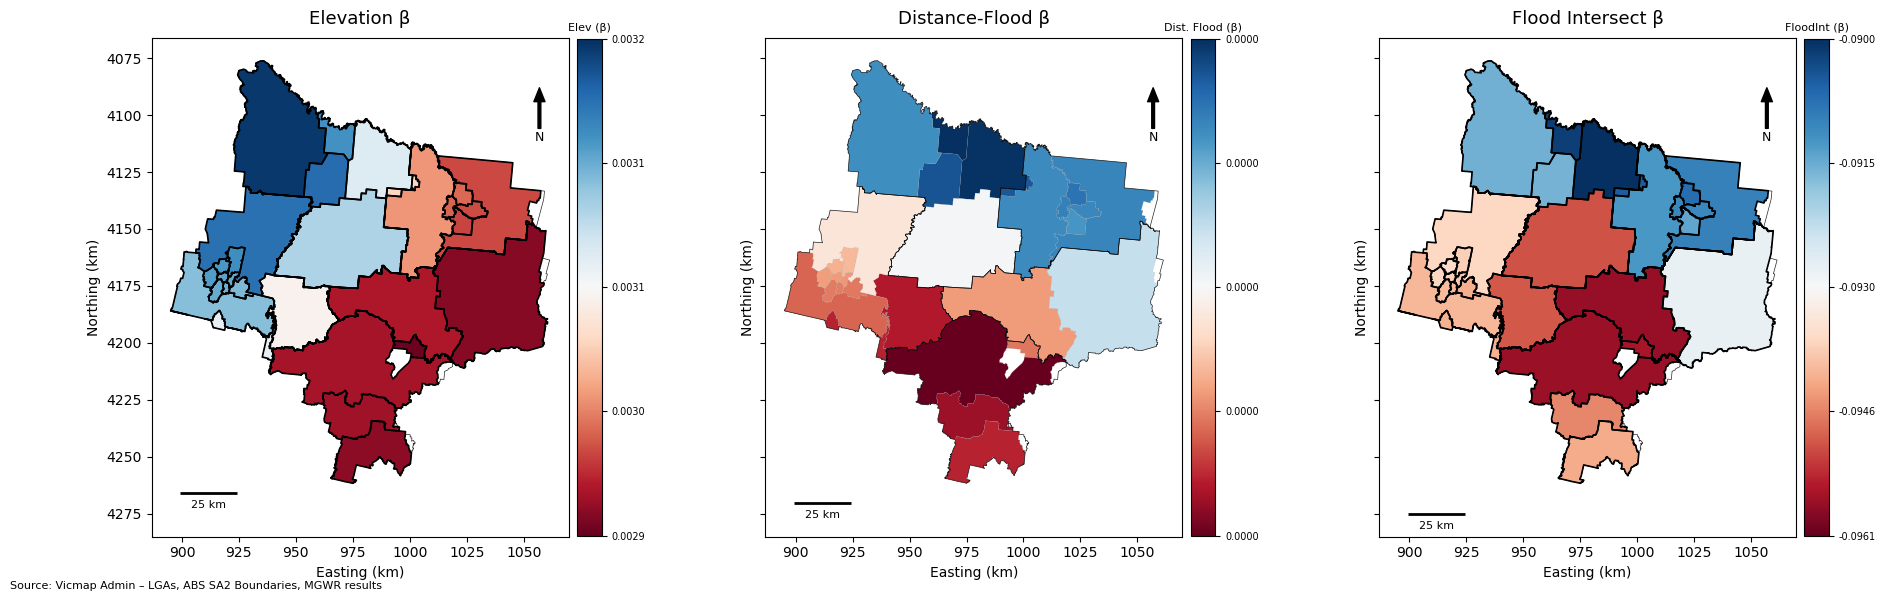

In [89]:
coefCols = ['bElevation', 'bDistFlood', 'bFloodIntersection']
gdf[coefCols] = res.params[:, 1:]

tVals = res.filter_tvals()[:, 1:]
sigCols = [f'{c}Sig' for c in coefCols]
gdf[sigCols] = (np.abs(tVals) > 2.09)

titles   = ['Elevation β', 'Distance-Flood β', 'Flood Intersect β']
cbarLabs = ['Elev (β)', 'Dist. Flood (β)', 'FloodInt (β)']
cmap     = 'RdBu'

fig, axs = plt.subplots(1, 3, figsize=(19, 6), sharex=True, sharey=True)

for ax, col, ttl, cblab in zip(axs, coefCols, titles, cbarLabs):
    vmin, vmax = gdf[col].min(), gdf[col].max()
    gdf.plot(column=col, cmap=cmap, vmin=vmin, vmax=vmax,
             edgecolor='0.6', linewidth=0.1, legend=False, ax=ax)
    lgaGDF.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.85)
    gdf[gdf[f'{col}Sig']].boundary.plot(ax=ax, color='black', linewidth=1.2)

    ax.annotate('N', xy=(0.93, 0.90), xytext=(0.93, 0.80),
                arrowprops=dict(facecolor='black', width=2,
                                headwidth=8, headlength=10),
                ha='center', va='center', xycoords='axes fraction', fontsize=9)

    sx = ax.get_xlim()[0] + 12500
    sy = ax.get_ylim()[0] +  5000
    ax.hlines(y=sy, xmin=sx, xmax=sx + 25000, colors='black', linewidth=2)
    ax.text(x=sx + 12500, y=sy - 6500, s='25 km', ha='center', fontsize=8)

    ax.set_xlabel('Easting (km)', fontsize=10)
    ax.set_ylabel('Northing (km)', fontsize=10)
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{abs(y)/1000:.0f}'))
    ax.set_title(ttl, fontsize=13, pad=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin, vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, fraction=0.045, pad=0.015)
    cbar.ax.set_title(cblab, fontsize=8, pad=6)
    ticks = np.linspace(vmin, vmax, 5)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{t:.4f}' for t in ticks])
    cbar.ax.tick_params(labelsize=7)

fig.text(0.01, 0.01,
         'Source: Vicmap Admin – LGAs, ABS SA2 Boundaries, MGWR results',
         fontsize=8, ha='left')
plt.tight_layout()
plt.show()

# <a id='toc5_'></a>[Discussion and Sustainability](#toc0_)

___

# <a id='toc6_'></a>[Conclusion](#toc0_)

___

# <a id='toc7_'></a>[References](#toc0_)

# <a id='toc7_1_'></a>[Dataset](#toc0_)

[1] Department of Education and Training, *School Locations 2024 (Victoria)* [Data set], 2024. [Online]. Available: https://www.education.vic.gov.au/Documents/about/research/datavic/dv309_schoollocations2021.csv

[2] Department of Environment, Land, Water & Planning, *Vicmap Admin – Local Government Area (LGA) Polygon Aligned to Topographic Features* [Data set], May 30, 2025. [Online]. Available: https://datashare.maps.vic.gov.au/search?q=uuid%3Dbc822a9c-3766-57ac-a034-bcad3fb66d86

[3] Department of Transport and Planning, *Vicmap Elevation DEM 10m* [Data set], 2016. [Online]. Available: https://datashare.maps.vic.gov.au/search?q=uuid%3D2fd9d712-5407-51df-bc75-bb13d37499af

[4] Victorian Department of Environment and Primary Industries, *Victoria – 1 in 100 Year Flood Extent* [Data set], Mar. 30, 2016. [Online]. Available: https://data.gov.au/data/dataset/b02df5ce-3c17-4948-8869-776ad49a4b82

[5] Australian Bureau of Statistics, *Socio-Economic Indexes for Areas (SEIFA), Australia, 2021* [Data set], 2021. [Online]. Available: https://www.abs.gov.au/statistics/people/people-and-communities/socio-economic-indexes-areas-seifa-australia/latest-release

[6] Australian Bureau of Statistics, *2021 General Community Profile – Statistical Area Level 2 (SA2), Victoria* [Data set], 2021. [Online]. Available: https://www.abs.gov.au/census/find-census-data/datapacks

[7] Australian Bureau of Statistics, *Australian Statistical Geography Standard (ASGS): Edition 3 – Digital Boundary Files* [Data set], Jul. 2021 – Jun. 2026. [Online]. Available: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files



# <a id='toc7_1_'></a>[Literature](#toc0_)

[1] Reckien, D., & Heiskanen, E. (2021). Equity, environmental justice, and climate change adaptation: Exploring the linkages and advancing the debate. Climatic Change, 167(3–4), Article 59. https://doi.org/10.1007/s10584-021-03059-3

[2] Department of Environment, Land, Water and Planning. (2016). Victorian floodplain management strategy: Parts 1 to 5. Victorian Government. https://www.water.vic.gov.au/__data/assets/pdf_file/0032/661739/victorian-floodplain-management-strategy-part-1-to-5.pdf

[3] Deloitte Access Economics. (2023). Cost of the October 2022 Victorian flood event: Final report [Prepared for Moira Shire Council]. Parliament of Victoria. https://www.parliament.vic.gov.au/49604a/contentassets/af5f665989af4facaa09a886d56ce0b0/reply-1.-qon-moira-shire-council-attach-1-deloitte_report_final-draft_august2023.pdf

[4] Ahmad, B. (2018). The role of socio-economic status in vulnerability to flood hazard. Academia.edu. https://www.academia.edu/37804191/The_Role_of_Socio_Economic_Status_in_Vulnerability_to_Flood_Hazard

[5] Schwarz, I., & Kuleshov, Y. (2022). Flood vulnerability assessment and mapping: A case study for Australia’s Hawkesbury–Nepean catchment. Remote Sensing, 14(19), 4894. https://doi.org/10.3390/rs14194894

https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-average-nearest-neighbor-distance-spatial-st.htm

___